In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import math
import random
from matplotlib import colors

import json
import zipfile

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip '/content/drive/MyDrive/Datos/MIMIC/Diferentes_horas.zip' -d ''
#!unzip '/content/drive/MyDrive/Datos/MIMIC/pacientes_chartevent.zip' -d ''

## Load Data
Se cargan los datos de series de tiempo (knn) y los estaticos (Xgboost)

### knn

In [110]:
#SERIES DE TIEMPO DE FRECUENCIA CARDIACA
columns= ['historia', 'ingreso','reingreso','fecha_ingreso','inicio_sepsis', 'fecha_egreso','sepsis','dato','fecha_registro','consecutivo']
#cambio total = pd.read_csv('/content/pacientes_chartevent_29Ago.csv')
# --marzo 30 -> total = pd.read_csv('/content/drive/MyDrive/Features2/serie.csv')
#prueba con series de tiempo por separado
fc = pd.read_csv('/content/drive/MyDrive/Features2/serie_fc.csv')
#Condiciones de calidad del dato
fc = fc[columns][((fc['consecutivo']!=7)|((fc['dato']<300)&(fc['dato']>0)))] #)&(((total['consecutivo']!=8)))|((total['dato']<400)&(total['dato']>0)))&(((total['consecutivo']!=9))|((total['dato']<300)&(total['dato']>0)))&(((total['consecutivo']!=104)))|((total['dato']<300)&(total['dato']>0)))&(((total['consecutivo']!=80))|((total['dato']<50)&(total['dato']>10)))]
#total_knn['value'] = total_knn[['value', 'itemid']].apply(lambda x: (x['value']-32)/1.8 if x['itemid']==223761 else x['value'], axis =1)
#total_knn.loc[total_knn['itemid'] == 223761, 'itemid'] = 223762
fc

,historia,ingreso,reingreso,fecha_ingreso,inicio_sepsis,fecha_egreso,sepsis,dato,fecha_registro,consecutivo
0,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,68.0,2018-11-28 13:31:40,7
1,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,82.0,2018-11-28 14:04:36,7
2,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,82.0,2018-11-28 16:06:07,7
3,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,82.0,2018-11-28 16:31:49,7
4,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,82.0,2018-11-28 17:03:12,7
...,...,...,...,...,...,...,...,...,...,...
881747,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,82.0,2016-03-31 12:40:08,7
881748,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,77.0,2016-03-31 14:47:06,7
881749,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,83.0,2016-03-31 16:39:05,7
881750,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,74.0,2016-03-31 18:40:15,7


In [111]:
#SERIES DE TIEMPO DE PRESION SISTÓLICA
columns= ['historia', 'ingreso','reingreso','fecha_ingreso','inicio_sepsis', 'fecha_egreso','sepsis','dato','fecha_registro','consecutivo']
#cambio total = pd.read_csv('/content/pacientes_chartevent_29Ago.csv')
# --marzo 30 -> total = pd.read_csv('/content/drive/MyDrive/Features2/serie.csv')
#prueba con series de tiempo por separado
sbp = pd.read_csv('/content/drive/MyDrive/Features2/serie_sbp.csv')
#Condiciones de calidad del dato
sbp = sbp[columns][((sbp['consecutivo']!=8)|((sbp['dato']<400)&(sbp['dato']>0)))] #)&(((total['consecutivo']!=8)))|((total['dato']<400)&(total['dato']>0)))&(((total['consecutivo']!=9))|((total['dato']<300)&(total['dato']>0)))&(((total['consecutivo']!=104)))|((total['dato']<300)&(total['dato']>0)))&(((total['consecutivo']!=80))|((total['dato']<50)&(total['dato']>10)))]
#total_knn['value'] = total_knn[['value', 'itemid']].apply(lambda x: (x['value']-32)/1.8 if x['itemid']==223761 else x['value'], axis =1)
#total_knn.loc[total_knn['itemid'] == 223761, 'itemid'] = 223762
sbp

,historia,ingreso,reingreso,fecha_ingreso,inicio_sepsis,fecha_egreso,sepsis,dato,fecha_registro,consecutivo
0,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,117,2018-11-28 13:31:40,8
1,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,111,2018-11-28 14:04:36,8
2,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,92,2018-11-28 16:06:07,8
3,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,103,2018-11-28 16:31:49,8
4,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,138,2018-11-28 17:03:12,8
...,...,...,...,...,...,...,...,...,...,...
882366,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,115,2016-03-31 12:40:08,8
882367,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,103,2016-03-31 14:47:06,8
882368,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,110,2016-03-31 16:39:05,8
882369,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,112,2016-03-31 18:40:15,8


In [112]:
#SERIES DE TIEMPO DE PRESION DIASTOLICA
columns= ['historia', 'ingreso','reingreso','fecha_ingreso','inicio_sepsis', 'fecha_egreso','sepsis','dato','fecha_registro','consecutivo']
#cambio total = pd.read_csv('/content/pacientes_chartevent_29Ago.csv')
# --marzo 30 -> total = pd.read_csv('/content/drive/MyDrive/Features2/serie.csv')
#prueba con series de tiempo por separado
dbp = pd.read_csv('/content/drive/MyDrive/Features2/serie_dbp.csv')
#Condiciones de calidad del dato
dbp = dbp[columns][((dbp['consecutivo']!=9)|((dbp['dato']<400)&(dbp['dato']>0)))] #)&(((total['consecutivo']!=8)))|((total['dato']<400)&(total['dato']>0)))&(((total['consecutivo']!=9))|((total['dato']<300)&(total['dato']>0)))&(((total['consecutivo']!=104)))|((total['dato']<300)&(total['dato']>0)))&(((total['consecutivo']!=80))|((total['dato']<50)&(total['dato']>10)))]
#total_knn['value'] = total_knn[['value', 'itemid']].apply(lambda x: (x['value']-32)/1.8 if x['itemid']==223761 else x['value'], axis =1)
#total_knn.loc[total_knn['itemid'] == 223761, 'itemid'] = 223762
dbp

,historia,ingreso,reingreso,fecha_ingreso,inicio_sepsis,fecha_egreso,sepsis,dato,fecha_registro,consecutivo
0,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,73,2018-11-28 13:31:40,9
1,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,71,2018-11-28 14:04:36,9
2,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,70,2018-11-28 16:06:07,9
3,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,74,2018-11-28 16:31:49,9
4,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,66,2018-11-28 17:03:12,9
...,...,...,...,...,...,...,...,...,...,...
882242,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,76,2016-03-31 12:40:08,9
882243,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,73,2016-03-31 14:47:06,9
882244,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,69,2016-03-31 16:39:05,9
882245,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,75,2016-03-31 18:40:15,9


In [113]:
#SERIES DE TIEMPO DE FRECUENCIA RESPIRATORIA
columns= ['historia', 'ingreso','reingreso','fecha_ingreso','inicio_sepsis', 'fecha_egreso','sepsis','dato','fecha_registro','consecutivo']
#cambio total = pd.read_csv('/content/pacientes_chartevent_29Ago.csv')
# --marzo 30 -> total = pd.read_csv('/content/drive/MyDrive/Features2/serie.csv')
#prueba con series de tiempo por separado
fr = pd.read_csv('/content/drive/MyDrive/Features2/serie_fr.csv')
#Condiciones de calidad del dato
fr = fr[columns][((fr['consecutivo']!=17)|((fr['dato']<70)&(fr['dato']>0)))] #)&(((total['consecutivo']!=8)))|((total['dato']<400)&(total['dato']>0)))&(((total['consecutivo']!=9))|((total['dato']<300)&(total['dato']>0)))&(((total['consecutivo']!=104)))|((total['dato']<300)&(total['dato']>0)))&(((total['consecutivo']!=80))|((total['dato']<50)&(total['dato']>10)))]
#total_knn['value'] = total_knn[['value', 'itemid']].apply(lambda x: (x['value']-32)/1.8 if x['itemid']==223761 else x['value'], axis =1)
#total_knn.loc[total_knn['itemid'] == 223761, 'itemid'] = 223762
fr

,historia,ingreso,reingreso,fecha_ingreso,inicio_sepsis,fecha_egreso,sepsis,dato,fecha_registro,consecutivo
0,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,17.0,2018-11-28 13:31:55,17
3,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,6.0,2018-11-28 18:00:31,17
4,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,17.0,2018-11-28 20:20:01,17
5,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,19.0,2018-11-28 22:10:23,17
6,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,16.0,2018-11-29 00:04:20,17
...,...,...,...,...,...,...,...,...,...,...
639632,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,22.0,2016-03-31 12:40:51,17
639633,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,21.0,2016-03-31 14:54:40,17
639634,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,16.0,2016-03-31 16:39:29,17
639635,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,19.0,2016-03-31 18:41:32,17


In [114]:
#SERIES DE TIEMPO DE GLASGOW
columns= ['historia', 'ingreso','reingreso','fecha_ingreso','inicio_sepsis', 'fecha_egreso','sepsis','dato','fecha_registro','consecutivo']
#cambio total = pd.read_csv('/content/pacientes_chartevent_29Ago.csv')
# --marzo 30 -> total = pd.read_csv('/content/drive/MyDrive/Features2/serie.csv')
#prueba con series de tiempo por separado
gw = pd.read_csv('/content/drive/MyDrive/Features2/serie_glasgow.csv')
#Condiciones de calidad del dato
gw = gw[columns][((gw['consecutivo']!=95)|((gw['dato']<15)&(gw['dato']>0)))] #)&(((total['consecutivo']!=8)))|((total['dato']<400)&(total['dato']>0)))&(((total['consecutivo']!=9))|((total['dato']<300)&(total['dato']>0)))&(((total['consecutivo']!=104)))|((total['dato']<300)&(total['dato']>0)))&(((total['consecutivo']!=80))|((total['dato']<50)&(total['dato']>10)))]
#total_knn['value'] = total_knn[['value', 'itemid']].apply(lambda x: (x['value']-32)/1.8 if x['itemid']==223761 else x['value'], axis =1)
#total_knn.loc[total_knn['itemid'] == 223761, 'itemid'] = 223762
gw

,historia,ingreso,reingreso,fecha_ingreso,inicio_sepsis,fecha_egreso,sepsis,dato,fecha_registro,consecutivo
0,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,8.0,2018-11-28 13:32:23,95
1,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,9.0,2018-11-28 16:02:01,95
2,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,11.0,2018-11-28 22:11:01,95
20,101292,36,0,2019-08-26 17:32:43,2019-08-26 18:53:31,2019-08-29 18:02:18,1,3.0,2019-08-26 18:12:23,95
21,101292,36,0,2019-08-26 17:32:43,2019-08-26 18:53:31,2019-08-29 18:02:18,1,6.0,2019-08-26 20:05:19,95
...,...,...,...,...,...,...,...,...,...,...
153948,97342,51,0,2019-09-15 06:30:35,2019-09-19 09:00:00,2019-09-17 16:01:38,0,11.0,2019-09-15 20:05:54,95
153949,97342,51,0,2019-09-15 06:30:35,2019-09-19 09:00:00,2019-09-17 16:01:38,0,11.0,2019-09-16 00:17:00,95
153950,97342,51,0,2019-09-15 06:30:35,2019-09-19 09:00:00,2019-09-17 16:01:38,0,11.0,2019-09-16 04:10:08,95
153951,97342,51,0,2019-09-15 06:30:35,2019-09-19 09:00:00,2019-09-17 16:01:38,0,11.0,2019-09-16 08:24:41,95


In [115]:
#SERIES DE TIEMPO DE GLUCOSE
columns= ['historia', 'ingreso','reingreso','fecha_ingreso','inicio_sepsis', 'fecha_egreso','sepsis','dato','fecha_registro','consecutivo']
#cambio total = pd.read_csv('/content/pacientes_chartevent_29Ago.csv')
# --marzo 30 -> total = pd.read_csv('/content/drive/MyDrive/Features2/serie.csv')
#prueba con series de tiempo por separado
gc = pd.read_csv('/content/drive/MyDrive/Features2/serie_glucose.csv')
#Condiciones de calidad del dato
gc = gc[columns][((gc['consecutivo']!=100)|((gw['dato']>0)))] #)&(((total['consecutivo']!=8)))|((total['dato']<400)&(total['dato']>0)))&(((total['consecutivo']!=9))|((total['dato']<300)&(total['dato']>0)))&(((total['consecutivo']!=104)))|((total['dato']<300)&(total['dato']>0)))&(((total['consecutivo']!=80))|((total['dato']<50)&(total['dato']>10)))]
#total_knn['value'] = total_knn[['value', 'itemid']].apply(lambda x: (x['value']-32)/1.8 if x['itemid']==223761 else x['value'], axis =1)
#total_knn.loc[total_knn['itemid'] == 223761, 'itemid'] = 223762
gc

,historia,ingreso,reingreso,fecha_ingreso,inicio_sepsis,fecha_egreso,sepsis,dato,fecha_registro,consecutivo
0,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,127.0,2018-11-28 13:31:40,100
1,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,152.0,2018-11-28 20:47:35,100
2,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,144.0,2018-11-29 02:02:26,100
20,101292,13,0,2016-05-08 12:20:53,2016-05-08 13:10:22,2016-05-22 14:23:45,1,155.0,2016-05-11 09:28:52,100
21,101292,13,0,2016-05-08 12:20:53,2016-05-08 13:10:22,2016-05-22 14:23:45,1,137.0,2016-05-11 14:11:36,100
...,...,...,...,...,...,...,...,...,...,...
153948,750406,5,0,2019-08-08 14:37:59,2019-08-11 09:00:00,2019-08-10 16:21:17,0,138.0,2019-08-09 04:34:58,100
153949,750406,5,0,2019-08-08 14:37:59,2019-08-11 09:00:00,2019-08-10 16:21:17,0,133.0,2019-08-09 08:05:32,100
153950,750406,5,0,2019-08-08 14:37:59,2019-08-11 09:00:00,2019-08-10 16:21:17,0,146.0,2019-08-09 19:13:03,100
153951,750406,5,0,2019-08-08 14:37:59,2019-08-11 09:00:00,2019-08-10 16:21:17,0,162.0,2019-08-10 06:27:15,100


In [116]:
#SERIES DE TIEMPO DE PRESION MEDIA
columns= ['historia', 'ingreso','reingreso','fecha_ingreso','inicio_sepsis', 'fecha_egreso','sepsis','dato','fecha_registro','consecutivo']
#cambio total = pd.read_csv('/content/pacientes_chartevent_29Ago.csv')
# --marzo 30 -> total = pd.read_csv('/content/drive/MyDrive/Features2/serie.csv')
#prueba con series de tiempo por separado
pm = pd.read_csv('/content/drive/MyDrive/Features2/serie_mean.csv')
#Condiciones de calidad del dato
pm = pm[columns][((pm['consecutivo']!=104)|((pm['dato']<300)&(pm['dato']>0)))] #)&(((total['consecutivo']!=8)))|((total['dato']<400)&(total['dato']>0)))&(((total['consecutivo']!=9))|((total['dato']<300)&(total['dato']>0)))&(((total['consecutivo']!=104)))|((total['dato']<300)&(total['dato']>0)))&(((total['consecutivo']!=80))|((total['dato']<50)&(total['dato']>10)))]
#total_knn['value'] = total_knn[['value', 'itemid']].apply(lambda x: (x['value']-32)/1.8 if x['itemid']==223761 else x['value'], axis =1)
#total_knn.loc[total_knn['itemid'] == 223761, 'itemid'] = 223762
pm

,historia,ingreso,reingreso,fecha_ingreso,inicio_sepsis,fecha_egreso,sepsis,dato,fecha_registro,consecutivo
0,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,87.666667,2018-11-28 13:31:40,104
1,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,84.333333,2018-11-28 14:04:36,104
2,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,77.333333,2018-11-28 16:06:07,104
3,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,83.666667,2018-11-28 16:31:49,104
4,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,90.000000,2018-11-28 17:03:12,104
...,...,...,...,...,...,...,...,...,...,...
882347,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,89.000000,2016-03-31 12:40:08,104
882348,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,83.000000,2016-03-31 14:47:06,104
882349,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,82.666667,2016-03-31 16:39:05,104
882350,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,87.333333,2016-03-31 18:40:15,104


In [117]:
#SERIES DE TIEMPO DE spO2
columns= ['historia', 'ingreso','reingreso','fecha_ingreso','inicio_sepsis', 'fecha_egreso','sepsis','dato','fecha_registro','consecutivo']
sp = pd.read_csv('//content/drive/MyDrive/Features2/serie_spo2.csv')
#Condiciones de calidad del dato
sp = sp[columns][((sp['consecutivo']!=127)|((sp['dato']<=100)&(sp['dato']>0)))] #)&(((total['consecutivo']!=8)))|((total['dato']<400)&(total['dato']>0)))&(((total['consecutivo']!=9))|((total['dato']<300)&(total['dato']>0)))&(((total['consecutivo']!=104)))|((total['dato']<300)&(total['dato']>0)))&(((total['consecutivo']!=80))|((total['dato']<50)&(total['dato']>10)))]
sp

,historia,ingreso,reingreso,fecha_ingreso,inicio_sepsis,fecha_egreso,sepsis,dato,fecha_registro,consecutivo
0,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,100.0,2018-11-28 13:31:55,127
1,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,97.0,2018-11-28 14:04:47,127
2,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,97.0,2018-11-28 16:32:03,127
3,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,99.0,2018-11-28 18:00:31,127
4,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,100.0,2018-11-28 20:20:01,127
...,...,...,...,...,...,...,...,...,...,...
643464,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,96.0,2016-03-31 12:40:51,127
643465,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,94.0,2016-03-31 14:54:40,127
643466,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,96.0,2016-03-31 16:39:29,127
643467,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,96.0,2016-03-31 18:41:32,127


In [118]:
#SERIES DE TIEMPO DE TEMP
columns= ['historia', 'ingreso','reingreso','fecha_ingreso','inicio_sepsis', 'fecha_egreso','sepsis','dato','fecha_registro','consecutivo']
tp = pd.read_csv('///content/drive/MyDrive/Features2/serie_temp.csv')
#Condiciones de calidad del dato
#tp = tp[columns][((tp['consecutivo']!=80)|((tp['dato']<=50)&(tp['dato']>0)))] #)&(((total['consecutivo']!=8)))|((total['dato']<400)&(total['dato']>0)))&(((total['consecutivo']!=9))|((total['dato']<300)&(total['dato']>0)))&(((total['consecutivo']!=104)))|((total['dato']<300)&(total['dato']>0)))&(((total['consecutivo']!=80))|((total['dato']<50)&(total['dato']>10)))]
tp

,historia,ingreso,reingreso,fecha_ingreso,inicio_sepsis,sepsis,fecha_registro,fecha_egreso,consecutivo,dato
0,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,0,2018-11-28 13:31:40,2018-11-29 21:34:38,80,35.2
1,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,0,2018-11-28 14:04:36,2018-11-29 21:34:38,80,35.4
2,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,0,2018-11-28 16:06:07,2018-11-29 21:34:38,80,35.4
3,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,0,2018-11-28 16:31:49,2018-11-29 21:34:38,80,36.4
4,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,0,2018-11-28 17:03:12,2018-11-29 21:34:38,80,36.2
...,...,...,...,...,...,...,...,...,...,...
881459,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,0,2016-03-31 12:40:08,2016-03-29 21:32:44,80,35.6
881460,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,0,2016-03-31 14:47:06,2016-03-29 21:32:44,80,36.5
881461,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,0,2016-03-31 16:39:05,2016-03-29 21:32:44,80,37.1
881462,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,0,2016-03-31 18:40:15,2016-03-29 21:32:44,80,36.9


In [119]:
#unión de todas lñas series de tiempo
total = pd.concat([fc,fr,sbp,dbp,gw,gc,pm,sp,tp])


In [120]:
total

,historia,ingreso,reingreso,fecha_ingreso,inicio_sepsis,fecha_egreso,sepsis,dato,fecha_registro,consecutivo
0,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,68.0,2018-11-28 13:31:40,7
1,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,82.0,2018-11-28 14:04:36,7
2,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,82.0,2018-11-28 16:06:07,7
3,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,82.0,2018-11-28 16:31:49,7
4,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,82.0,2018-11-28 17:03:12,7
...,...,...,...,...,...,...,...,...,...,...
881459,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,35.6,2016-03-31 12:40:08,80
881460,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,36.5,2016-03-31 14:47:06,80
881461,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,37.1,2016-03-31 16:39:05,80
881462,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,36.9,2016-03-31 18:40:15,80


### XGBoost

In [167]:
data_forest = pd.read_csv('/content/drive/MyDrive/Features2/output32.csv', delimiter =',')
data_forest

,historia,fecha_ingreso,inicio_sepsis,delirio,sepsis
0,100133,2018-11-28 13:12:55,2018-11-29 21:00:00,0.0,0
1,101292,2016-05-08 12:20:53,2016-05-08 13:10:22,NaN,1
2,101292,2019-08-26 17:32:43,2019-08-26 18:53:31,NaN,1
3,101548,2018-12-02 17:59:13,2018-12-03 11:34:47,0.0,1
4,101680,2018-03-23 12:48:41,2018-03-25 03:00:00,0.0,0
...,...,...,...,...,...
4701,97525,2016-12-10 19:01:31,2016-12-10 21:20:52,NaN,1
4702,97664,2017-06-28 12:36:47,2017-06-29 21:00:00,0.0,0
4703,97868,2016-07-23 11:20:36,2016-07-25 06:00:00,NaN,0
4704,98010,2016-07-03 03:46:52,2016-07-03 11:11:18,NaN,1


In [171]:
#FeaturesCargar los datos para el modelo XGBOOST
data_forest = pd.read_csv('/content/drive/MyDrive/Features2/output1.csv', delimiter =',')

for i in range(2,32):
  data_forest = pd.merge(data_forest, pd.read_csv('/content/drive/MyDrive/Features2/output'+str(i)+'.csv', delimiter =','), on=['historia','fecha_ingreso','inicio_sepsis', 'sepsis' ])
data_forest

,historia,fecha_ingreso,inicio_sepsis,sepsis,heartrate_min,heartrate_max,heartrate_stddev,tempc_min,tempc_max,temp_stddev,sysbp_min,sysbp_max,sysbp_stddev,diasbp_min,diasbp_max,diasbp_stddev,meanbp_min,meanbp_max,meanbp_stddev,spo2_min,spo2_max,spo2_stddev,glucose_min,glucose_max,glucose_stddev,resprate_min,resprate_max,resprate_stddev,glasgow_min,glasgow_max,glasgow_stddev,hematocrit_min,hematocrit_max,hematocrit_stddev,hemoglobin_min,hemoglobin_max,hemoglobin_stddev,creatinine_min,creatinine_max,creatinine_stddev,...,platelet_max,platelet_stddev,wbc_min,wbc_max,wbc_stddev,age,monocito_min,monocito_max,monocito_stddev,neutrofilo_min,neutrofilo_max,neutrofilo_stddev,eosinofilo_min,eosinofilo_max,eosinofilo_stddev,basofilo_min,basofilo_max,basofilo_stddev,leucocito_min,leucocito_max,leucocito_stddev,cancer,hta,diabetes,ph_min,ph_max,ph_stddev,cardiovascular,dislipidemia,peso,imc,fio2_min,fio2_max,fio2_stddev,co2_min,co2_max,cro2_stddev,bun_min,bun_max,bun_stddev
0,100133,2018-11-28 13:12:55,2018-12-03 00:00:00,0,68.0,68.0,68.000000,NaN,NaN,NaN,81.0,81.0,81.000000,50.0,50.0,50.000000,68.0,68.0,68.000000,91.0,91.0,91.000000,81.0,81.0,81.00000,0.0,0.0,0.000000,8.0,8.0,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,1,1,68.6,68.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101292,2016-05-08 12:20:53,2016-05-08 13:10:22,1,53.0,53.0,53.000000,NaN,NaN,NaN,71.0,71.0,71.000000,35.0,35.0,35.000000,59.0,59.0,59.000000,84.0,84.0,84.000000,20.0,20.0,20.00000,0.0,0.0,0.000000,3.0,3.0,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101292,2019-08-26 17:32:43,2019-08-26 18:53:31,1,53.0,53.0,53.000000,NaN,NaN,NaN,71.0,71.0,71.000000,35.0,35.0,35.000000,59.0,59.0,59.000000,84.0,84.0,84.000000,20.0,20.0,20.00000,0.0,0.0,0.000000,3.0,3.0,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,101548,2018-12-02 17:59:13,2018-12-03 11:34:47,1,76.0,135.0,15.426033,35.9,37.5,0.620181,103.0,139.0,9.264403,53.0,98.0,13.745302,88.0,90.0,1.154701,91.0,97.0,1.732051,112.0,140.0,11.50000,15.0,30.0,4.176655,11.0,15.0,1.788854,41.8,41.8,NaN,14.1,14.1,NaN,1.71,1.71,NaN,...,397.0,NaN,26.5,26.5,NaN,51,0.9,0.9,NaN,24.8,24.8,NaN,0.0,0.0,NaN,0.0,0.0,NaN,26.5,26.5,NaN,1,1,1,7.5,7.51,0.007071,1,1,78.0,78.0,32.0,50.0,12.727922,37.2,40.5,2.333452,47.0,47.0,NaN
4,101680,2018-03-23 12:48:41,2018-03-27 12:00:00,0,81.0,83.0,1.414214,36.0,36.4,0.282843,103.0,110.0,4.949747,58.0,59.0,0.707107,73.0,76.0,2.121320,88.0,90.0,1.414214,88.0,88.0,88.00000,14.0,16.0,1.414214,3.0,3.0,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,1,1,53.0,53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701,97525,2016-12-10 19:01:31,2016-12-10 21:20:52,1,116.0,116.0,58.000000,37.6,37.6,NaN,147.0,147.0,11.000000,65.0,65.0,30.000000,37.0,37.0,37.000000,48.0,48.0,48.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,55.0,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4702,97664,2017-06-28 12:36:47,2017-07-02 21:00:00,0,82.0,82.0,82.000000,NaN,NaN,NaN,11.0,11.0,11.000000,29.0,29.0,29.000000,52.0,52.0,52.000000,92.0,92.0,92.000000,49.0,49.0,49.00000,0.0,0.0,0.000000,N

In [172]:
#Creación de cuatro variables adicionales
data_forest['si_min'] = data_forest['heartrate_min']/data_forest['sysbp_min']
data_forest['si_max'] = data_forest['heartrate_max']/data_forest['sysbp_max']
data_forest['prueba3'] = data_forest['sysbp_min']*data_forest['age']
data_forest['prueba2'] = data_forest['sysbp_max']*data_forest['age']

In [173]:
data_forest['sepsis'].value_counts()

0    3570
1    1136
Name: sepsis, dtype: int64

In [174]:
data_forest

,historia,fecha_ingreso,inicio_sepsis,sepsis,heartrate_min,heartrate_max,heartrate_stddev,tempc_min,tempc_max,temp_stddev,sysbp_min,sysbp_max,sysbp_stddev,diasbp_min,diasbp_max,diasbp_stddev,meanbp_min,meanbp_max,meanbp_stddev,spo2_min,spo2_max,spo2_stddev,glucose_min,glucose_max,glucose_stddev,resprate_min,resprate_max,resprate_stddev,glasgow_min,glasgow_max,glasgow_stddev,hematocrit_min,hematocrit_max,hematocrit_stddev,hemoglobin_min,hemoglobin_max,hemoglobin_stddev,creatinine_min,creatinine_max,creatinine_stddev,...,wbc_stddev,age,monocito_min,monocito_max,monocito_stddev,neutrofilo_min,neutrofilo_max,neutrofilo_stddev,eosinofilo_min,eosinofilo_max,eosinofilo_stddev,basofilo_min,basofilo_max,basofilo_stddev,leucocito_min,leucocito_max,leucocito_stddev,cancer,hta,diabetes,ph_min,ph_max,ph_stddev,cardiovascular,dislipidemia,peso,imc,fio2_min,fio2_max,fio2_stddev,co2_min,co2_max,cro2_stddev,bun_min,bun_max,bun_stddev,si_min,si_max,prueba3,prueba2
0,100133,2018-11-28 13:12:55,2018-12-03 00:00:00,0,68.0,68.0,68.000000,NaN,NaN,NaN,81.0,81.0,81.000000,50.0,50.0,50.000000,68.0,68.0,68.000000,91.0,91.0,91.000000,81.0,81.0,81.00000,0.0,0.0,0.000000,8.0,8.0,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,1,1,68.6,68.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.839506,0.839506,5994.0,5994.0
1,101292,2016-05-08 12:20:53,2016-05-08 13:10:22,1,53.0,53.0,53.000000,NaN,NaN,NaN,71.0,71.0,71.000000,35.0,35.0,35.000000,59.0,59.0,59.000000,84.0,84.0,84.000000,20.0,20.0,20.00000,0.0,0.0,0.000000,3.0,3.0,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.746479,0.746479,5396.0,5396.0
2,101292,2019-08-26 17:32:43,2019-08-26 18:53:31,1,53.0,53.0,53.000000,NaN,NaN,NaN,71.0,71.0,71.000000,35.0,35.0,35.000000,59.0,59.0,59.000000,84.0,84.0,84.000000,20.0,20.0,20.00000,0.0,0.0,0.000000,3.0,3.0,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.746479,0.746479,5609.0,5609.0
3,101548,2018-12-02 17:59:13,2018-12-03 11:34:47,1,76.0,135.0,15.426033,35.9,37.5,0.620181,103.0,139.0,9.264403,53.0,98.0,13.745302,88.0,90.0,1.154701,91.0,97.0,1.732051,112.0,140.0,11.50000,15.0,30.0,4.176655,11.0,15.0,1.788854,41.8,41.8,NaN,14.1,14.1,NaN,1.71,1.71,NaN,...,NaN,51,0.9,0.9,NaN,24.8,24.8,NaN,0.0,0.0,NaN,0.0,0.0,NaN,26.5,26.5,NaN,1,1,1,7.5,7.51,0.007071,1,1,78.0,78.0,32.0,50.0,12.727922,37.2,40.5,2.333452,47.0,47.0,NaN,0.737864,0.971223,5253.0,7089.0
4,101680,2018-03-23 12:48:41,2018-03-27 12:00:00,0,81.0,83.0,1.414214,36.0,36.4,0.282843,103.0,110.0,4.949747,58.0,59.0,0.707107,73.0,76.0,2.121320,88.0,90.0,1.414214,88.0,88.0,88.00000,14.0,16.0,1.414214,3.0,3.0,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,1,1,53.0,53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.786408,0.754545,5871.0,6270.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701,97525,2016-12-10 19:01:31,2016-12-10 21:20:52,1,116.0,116.0,58.000000,37.6,37.6,NaN,147.0,147.0,11.000000,65.0,65.0,30.000000,37.0,37.0,37.000000,48.0,48.0,48.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0,55.0,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.789116,0.789116,8820.0,8820.0
4702,97664,2017-06-28 12:36:47,2017-07-02 21:00:00,0,82.0,82.0,82.000000,NaN,NaN,NaN,11.0,11.0,11.000000,29.0,29.0,29.000000,

In [175]:
#datos en columnas
columns = [ 'si_min', 'glasgow_min', 'glasgow_stddev', 'age', 
           'cancer', 'hta', 'diabetes',
           'prueba3',  'cardiovascular', 'dislipidemia', 'peso', 'imc', 
            'sysbp_min', 'sysbp_max','sysbp_stddev', 'resprate_min', 
           'resprate_max', 'resprate_stddev',
          'diasbp_max', 'diasbp_min','diasbp_stddev', 'spo2_min', 'spo2_stddev',
          'heartrate_max','heartrate_min','heartrate_stddev',  
             'glucose_min', 'glucose_max', 'wbc_max', 'wbc_min', 'wbc_stddev',
        'platelet_min', 'platelet_max', 'hematocrit_min',	'hematocrit_max',	
        'hematocrit_stddev'	,'hemoglobin_min',	'hemoglobin_max',	'hemoglobin_stddev'
        ,'tempc_max', 'tempc_min', 'temp_stddev'
       ,'monocito_min',	'monocito_max',	'monocito_stddev',	'neutrofilo_min',
       	'neutrofilo_max',	'neutrofilo_stddev',	'eosinofilo_min',
         	'eosinofilo_max','eosinofilo_stddev',	'basofilo_min','basofilo_max',
           'basofilo_stddev', 'ph_min',	'ph_max',	'ph_stddev'
       ,'leucocito_min' , 'leucocito_max', 'fio2_min','fio2_max','fio2_stddev',
       'co2_min','co2_max','cro2_stddev','bun_min','bun_max', 'bun_stddev'
        'creatinine_min',	'creatinine_max',
         'creatinine_stddev', 'sepsis'
        ]

In [ ]:
# GINI > 0.11
Xsepsis = total [[ 'si_min', 'glasgow_min', 'glasgow_stddev', 'age',                 
            'sysbp_stddev', 'resprate_min',         
           'diasbp_stddev',  'spo2_stddev',
          'heartrate_max','heartrate_min','heartrate_stddev',  
             'glucose_max', 
        'tempc_max', 'tempc_min', 'temp_stddev'
       ,'monocito_min',	'monocito_max',	'monocito_stddev',	'neutrofilo_min',
       	'neutrofilo_max',	'neutrofilo_stddev',	'eosinofilo_min',
         	'eosinofilo_max','eosinofilo_stddev',	
           'basofilo_stddev', 'hemoglobin_min', 'hemoglobin_max',
       'leucocito_min' , 'leucocito_max', 'fio2_min','fio2_max',
       'co2_min','co2_max','bun_min','bun_max',
       	 'creatinine_min',	'creatinine_max',
         'creatinine_stddev'
        ]]

In [ ]:
#info_gain >0.018
Xsepsis = total [[ 'si_min', 'glasgow_min', 'glasgow_stddev',  
             'sysbp_max','sysbp_stddev', 'resprate_min', 
           'diasbp_max', 'diasbp_stddev', 'spo2_min', 'spo2_stddev',
          'heartrate_max','heartrate_min','heartrate_stddev',  
             'glucose_min', 'glucose_max', 
        'tempc_max', 'tempc_min', 'temp_stddev'
       ,'monocito_min',	'monocito_max',	'monocito_stddev',	'neutrofilo_min',
       	'neutrofilo_max',	'neutrofilo_stddev',	'eosinofilo_min',
         	'eosinofilo_max','eosinofilo_stddev',	
           'basofilo_stddev'
       ,'leucocito_min' , 'leucocito_max', 'fio2_min','fio2_max',
       'co2_min','co2_max','bun_min','bun_max',
       	#'pcr_min','pcr_max'
        ]]

In [ ]:
#GAIN RATIO
Xsepsis = total [[ 'si_min', 'glasgow_min', 'glasgow_stddev', 'age', 
                   
            'sysbp_min', 'sysbp_stddev', 'resprate_min', 
           'resprate_max', 'resprate_stddev',
           'diasbp_min','diasbp_stddev', 'spo2_min', 'spo2_stddev',
          'heartrate_max','heartrate_min','heartrate_stddev',  
             'glucose_min', 'glucose_max', 'wbc_max', 'wbc_min', 'wbc_stddev',
        'platelet_min', 'platelet_max', 'hematocrit_min',	'hematocrit_max',	
        'hematocrit_stddev'	,'hemoglobin_min',	'hemoglobin_max',	'hemoglobin_stddev'
        ,'tempc_max', 'tempc_min', 'temp_stddev'
       ,'monocito_min',	'monocito_max',	'monocito_stddev',	'neutrofilo_min',
       	'neutrofilo_max',	'neutrofilo_stddev',	'eosinofilo_min',
         	'eosinofilo_max','eosinofilo_stddev',	'basofilo_max',
           'basofilo_stddev'
       ,'leucocito_min' , 'leucocito_max', 'fio2_min','fio2_max',
       'co2_min','co2_max','bun_min','bun_max',
        'creatinine_min',	'creatinine_max',
         'creatinine_stddev' 
        ]]

In [176]:
#paso # 2
#seleccion aleatoria de los grupos de entrenamiento y test
np.random.seed(42)
p_ids = np.random.permutation(data_forest[np.isin(data_forest['historia'], total['historia'].unique()) & (data_forest['sepsis']==1)]['historia'].values)
p_train, p_test = p_ids[:500], p_ids[800:]

n_ids = np.random.permutation(data_forest[np.isin(data_forest['historia'], total['historia'].unique()) & (data_forest['sepsis']==0)]['historia'].values)
n_train, n_test = n_ids[:500], n_ids[:800]# se cambia de 800 a 2000

train_index_sp = np.concatenate((p_train, n_train))
test_index_sp = np.concatenate((p_test, n_test))

In [177]:
len(n_train)

500

In [180]:
len(test_index_sp)

1136

In [181]:
len(n_test)

800

In [182]:
len(train_index_sp)

1000

In [183]:
train_index_sp
test_index_sp

array([758046, 740436, 382925, ..., 808478, 638476, 735447])

In [184]:
#Escalamiento de datos using The z-score method. see: https://towardsdatascience.com/data-normalization-with-pandas-and-scikit-learn-7c1cc6ed6475
limits = total[np.isin(total['historia'], train_index_sp)][['consecutivo','dato']].groupby('consecutivo')['dato'].apply(pd.to_numeric).agg(['mean', 'std'])
total['dato'] = total[['dato']].apply(lambda x: 200 + (x['dato'] -limits['mean']) /(limits['std']), axis=1)

In [185]:
limits

mean      76.665292
std     1067.573272
Name: dato, dtype: float64

In [80]:
total

,historia,ingreso,reingreso,fecha_ingreso,inicio_sepsis,fecha_egreso,sepsis,dato,fecha_registro,consecutivo
0,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,199.793358,2018-11-28 13:31:40,7
1,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,200.163263,2018-11-28 14:04:36,7
2,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,200.163263,2018-11-28 16:06:07,7
3,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,200.163263,2018-11-28 16:31:49,7
4,100133,22,0,2018-11-28 13:12:55,2018-12-03 00:00:00,2018-11-29 21:34:38,0,200.163263,2018-11-28 17:03:12,7
...,...,...,...,...,...,...,...,...,...,...
881459,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,198.937291,2016-03-31 12:40:08,80
881460,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,198.961071,2016-03-31 14:47:06,80
881461,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,198.976924,2016-03-31 16:39:05,80
881462,98487,5,0,2016-03-28 17:49:30,2016-04-02 03:00:00,2016-03-29 21:32:44,0,198.971640,2016-03-31 18:40:15,80


## Datos como arreglos

In [186]:
#seleccion de pacientes sin sepsis, sepsis_final = 0
no_sepsis = total[(total['sepsis']==0) & (np.isin(total['historia'], train_index_sp) | np.isin(total['historia'], test_index_sp))]
#no_sepsis = no_sepsis[((no_sepsis['itemid']!=220045)|((no_sepsis['value']<300)&(no_sepsis['value']>0)))&(((no_sepsis['itemid']!=220050)&(no_sepsis['itemid']!=220179))|((no_sepsis['value']<400)&(no_sepsis['value']>0)))&(((no_sepsis['itemid']!=220051)&(no_sepsis['itemid']!=220180))|((no_sepsis['value']<300)&(no_sepsis['value']>0)))&(((no_sepsis['itemid']!=220052)&(no_sepsis['itemid']!=220181)&(no_sepsis['itemid']!=225312))|((no_sepsis['value']<300)&(no_sepsis['value']>0)))&(((no_sepsis['itemid']!=220210)&(no_sepsis['itemid']!=224690))|((no_sepsis['value']<70)&(no_sepsis['value']>0)))&(((no_sepsis['itemid']!=223762))|((no_sepsis['value']<50)&(no_sepsis['value']>10)))&(((no_sepsis['itemid']!=223761))|((no_sepsis['value']<120)&(no_sepsis['value']>70)))&(((no_sepsis['itemid']!=220277))|((no_sepsis['value']<=100)&(no_sepsis['value']>0)))]
no_sepsis = no_sepsis.reset_index().drop(columns='index')
no_sepsis

,historia,ingreso,reingreso,fecha_ingreso,inicio_sepsis,fecha_egreso,sepsis,dato,fecha_registro,consecutivo
0,104513,49,0,2016-12-06 16:09:55,2016-12-09 03:00:00,2016-12-10 15:45:29,0,199.999377,2016-12-06 17:04:58,7
1,104513,49,0,2016-12-06 16:09:55,2016-12-09 03:00:00,2016-12-10 15:45:29,0,199.993757,2016-12-06 17:06:10,7
2,104513,49,0,2016-12-06 16:09:55,2016-12-09 03:00:00,2016-12-10 15:45:29,0,199.990010,2016-12-06 18:01:50,7
3,104513,49,0,2016-12-06 16:09:55,2016-12-09 03:00:00,2016-12-10 15:45:29,0,199.993757,2016-12-06 19:05:43,7
4,104513,49,0,2016-12-06 16:09:55,2016-12-09 03:00:00,2016-12-10 15:45:29,0,199.995630,2016-12-06 20:42:32,7
...,...,...,...,...,...,...,...,...,...,...
813000,96961,5,0,2017-11-20 14:21:47,2017-11-24 09:00:00,2017-11-24 14:19:01,0,199.961909,2017-11-27 03:03:47,80
813001,96961,5,0,2017-11-20 14:21:47,2017-11-24 09:00:00,2017-11-24 14:19:01,0,199.962377,2017-11-27 04:29:24,80
813002,96961,5,0,2017-11-20 14:21:47,2017-11-24 09:00:00,2017-11-24 14:19:01,0,199.960785,2017-11-27 06:23:06,80
813003,96961,5,0,2017-11-20 14:21:47,2017-11-24 09:00:00,2017-11-24 14:19:01,0,199.962190,2017-11-27 08:25:37,80


## Datos como arreglos

In [187]:
keys = {
    
}


s_explicit = {
    
}

s_final = {
    
}


periodos= {
    
}



series = {
    7:0,   # FC
    80:1,  #temp
    8:2,    #sysBP  
    9:3 ,   #diasBP
    104:4,  #meanBP
    17:5 ,  #FR
    127:6, #SpO2
    100:7,  #Glucose 
    
}

def get_period(ini, fin):#ini: hora de ingreso del paciente - fin: La variable fin es la hora de cada registro de FC o de las demás variables
  return int(np.round((fin-ini)/np.timedelta64(1, 'h'))) # calcula la posición en el arreglo en el que se marca cada medición por que se está agrupando por horas

def get_series(consecutivo):#Saca a que serie pertenece cada medición, a que historia pertenece cada serie
  if consecutivo in series:
    return series[consecutivo]
  return -1

def get_key(historia):
  if historia in keys:
    return keys[historia]
  return -1


mat=[] #matriz donde se va a meter todo
curr=0 #el indice de la nueva tabla
for i in range(len(no_sepsis)):
  row = no_sepsis.loc[i]
  i1=get_key(row['historia'])
  i2=get_series(row['consecutivo'])
  i3=get_period(pd.Timestamp(row['fecha_ingreso']), pd.Timestamp(row['fecha_registro']))
  if i1 == -1:# si no está el número de historia, le crea el arreglo con ceros
    a=np.zeros(1+int(np.ceil(get_period(pd.Timestamp(row['fecha_ingreso']), pd.Timestamp(row['fecha_egreso'])))))# arreglo de ceros con el número de horas que estuvo en la UCI
    mat.append([a.copy(),a.copy(),a.copy(),a.copy(),a.copy(),a.copy(),a.copy(),a.copy()])#para ingresas ceros por cada variable. <--cambio 9abril se agrega un a.copy
    keys[row['historia']]=curr #curr es un contador
    #s_explicit[curr] = row['sepsis']
    s_final[curr] = row['sepsis']
    #s_pulmon[curr] = row['sepsis_pulmon'] #cambio#
    #s_cardio[curr] = row['sepsis_cardio']
    #s_gcs[curr] = row['sepsis_gcs']
    #s_urine[curr] = row['sepsis_urine']
    curr+=1
    print(curr)
  elif i2 !=-1:
    if i3<len(mat[i1][i2]) and i3>=0:
      #print((i1,i2,i3))
      mat[i1][i2][i3]=row['dato']
    
series_no_sepsis = pd.DataFrame(mat)

series_no_sepsis['historia']=np.zeros(len(series_no_sepsis.index))
#series_no_sepsis['sepsis']=np.zeros(len(series_no_sepsis.index))
series_no_sepsis['sepsis']=np.zeros(len(series_no_sepsis.index))
#series_no_sepsis['sepsis_pulmon']=np.zeros(len(series_no_sepsis.index)) #cambio
#series_no_sepsis['sepsis_cardio']=np.zeros(len(series_no_sepsis.index))
#series_no_sepsis['sepsis_gcs']=np.zeros(len(series_no_sepsis.index))
#series_no_sepsis['sepsis_urine']=np.zeros(len(series_no_sepsis.index))
for k in keys:
  series_no_sepsis['historia'][keys[k]] = k
  #series_no_sepsis['sepsis'][keys[k]] = s_explicit[keys[k]]
  series_no_sepsis['sepsis'][keys[k]]= s_final[keys[k]]
  #series_no_sepsis['sepsis_pulmon'][keys[k]] = s_pulmon[keys[k]]  #cambio
  #series_no_sepsis['sepsis_cardio'][keys[k]] = s_cardio[keys[k]]
  #series_no_sepsis['sepsis_gcs'][keys[k]] = s_gcs[keys[k]]
  #series_no_sepsis['sepsis_urine'][keys[k]] = s_urine[keys[k]]

np.random.seed(42)
series_no_sepsis['periodo'] = series_no_sepsis.apply(lambda x: np.random.randint(4, high=max(len(x[0])+1, 5)), axis=1)
series_no_sepsis['periodo']
series_no_sepsis

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,0,1,2,3,4,5,6,7,historia,sepsis,periodo
0,"[0.0, 199.99375659555326, 199.99000978013063, ...","[0.0, 199.9619086644609, 199.96237701638873, 1...","[0.0, 200.05089553074836, 200.0415284921918, 2...","[0.0, 199.99094648398628, 199.99094648398628, ...","[0.0, 200.01092949957365, 200.00780715338811, ...","[0.0, 199.94317458734776, 199.94973151433734, ...","[0.0, 200.02185771122296, 200.02092100736732, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",104513.0,0.0,55
1,"[0.0, 199.97595922229576, 199.97408581458444, ...","[199.96097196060524, 199.96228334600318, 199.9...","[200.02185771122296, 200.04808541918138, 200.0...","[199.9750225184401, 199.98813637241932, 199.97...","[199.99063424936773, 200.00811938800666, 199.9...","[199.94504799505907, 199.95160492204866, 0.0, ...","[200.02185771122296, 200.02185771122296, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",106259.0,0.0,32
2,"[0.0, 200.02466782278995, 200.0321614536352, 2...","[0.0, 199.96284536831655, 199.96265802754542, ...","[0.0, 200.07056631171716, 200.084616869552, 20...","[0.0, 200.00218693025417, 200.00406033796548, ...","[0.0, 200.0249800574085, 200.030912515161, 199...","[0.0, 199.95628844132696, 0.0, 199.93287084493...","[0.0, 200.01811089580033, 200.01623748808902, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",108589.0,0.0,18
3,"[0.0, 0.0, 0.0, 0.0, 200.0124906726664, 200.01...","[0.0, 199.9594732344362, 0.0, 0.0, 199.9621896...","[0.0, 200.0696296078615, 0.0, 0.0, 200.0265412...","[0.0, 199.98251614928537, 0.0, 0.0, 199.989073...","[0.0, 200.01155396881074, 0.0, 0.0, 200.001562...","[0.0, 199.9422378834921, 0.0, 0.0, 199.9300607...","[0.0, 200.02092100736732, 0.0, 0.0, 200.017174...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",110879.0,0.0,110
4,"[0.0, 200.00406033796548, 0.0, 199.99563000326...","[0.0, 199.96087829021968, 0.0, 199.96144031253...","[0.0, 200.05370564231532, 0.0, 200.03403486134...","[0.0, 199.98719966856365, 0.0, 199.97502251844...","[0.0, 200.00936832648088, 0.0, 199.99469329940...","[0.0, 199.94692140277039, 0.0, 0.0, 0.0, 199.9...","[0.0, 200.019047599656, 0.0, 200.0218577112229...","[0.0, 200.09679401967557, 0.0, 200.02935134206...",113580.0,0.0,11
...,...,...,...,...,...,...,...,...,...,...,...
788,"[0.0, 0.0, 199.99188318784195, 199.99188318784...","[0.0, 199.9607846198341, 199.96228334600318, 1...","[0.0, 199.94317458734776, 200.05932586544927, ...","[0.0, 200.01061726495507, 199.99375659555326, ...","[0.0, 199.98813637241932, 200.01561301885192, ...","[0.0, 199.94411129120343, 199.94785810662606, ...","[0.0, 200.02185771122296, 200.0171741919447, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9110.0,0.0,9
789,"[0.0, 0.0, 199.9797060377184, 199.980642741574...","[0.0, 199.9619086644609, 199.9619086644609, 19...","[0.0, 200.03965508448047, 200.019047599656, 20...","[0.0, 199.97783263000707, 199.96752888759485, ...","[0.0, 199.99844011483154, 199.98470179161524, ...","[0.0, 199.93849106806948, 199.94973151433734, ...","[0.0, 200.01623748808902, 200.02092100736732, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",92124.0,0.0,19
790,"[0.0, 0.0, 199.99656670712022, 199.99469329940...","[199.9605036086774, 0.0, 199.96097196060524, 1...","[200.019047599656, 0.0, 200.02466782278995, 20...","[199.97876933386274, 0.0, 199.99375659555326, ...","[199.9921954224605, 0.0, 200.00406033796548, 2...","[199.94598469891474, 0.0, 199.95628844132696, ...","[200.02092100736732, 0.0, 200.01811089580033, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",93271.0,0.0,11
791,"[200.00406033796548, 199.99563000326458, 0.0, ...","[199.96172132368977, 199.96181499407533, 0.0, ...","[200.08368016569636, 200.07524983099543, 0.0, ...","[200.00968056109943, 200.0059337456768, 0.0, 1...","[200.03434709596507, 200.02903910744968, 0.0, ...","[199.94785810662606, 0.0, 0.0, 199.95066821819...","[200.01998430351165, 0.0, 0.0, 200.02092100736...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",94006.0,0.0,7


In [188]:
sepsis = total[(total['sepsis']==1) & (np.isin(total['historia'], train_index_sp) | np.isin(total['historia'], test_index_sp))]
#sepsis = sepsis[((sepsis['itemid']!=220045)|((sepsis['value']<300)&(sepsis['value']>0)))&(((sepsis['itemid']!=220050)&(sepsis['itemid']!=220179))|((sepsis['value']<400)&(sepsis['value']>0)))&(((sepsis['itemid']!=220051)&(sepsis['itemid']!=220180))|((sepsis['value']<300)&(sepsis['value']>0)))&(((sepsis['itemid']!=220052)&(sepsis['itemid']!=220181)&(sepsis['itemid']!=225312))|((sepsis['value']<300)&(sepsis['value']>0)))&(((sepsis['itemid']!=220210)&(sepsis['itemid']!=224690))|((sepsis['value']<70)&(sepsis['value']>0)))&(((sepsis['itemid']!=223762))|((sepsis['value']<50)&(sepsis['value']>10)))&(((sepsis['itemid']!=223761))|((sepsis['value']<120)&(sepsis['value']>70)))&(((sepsis['itemid']!=220277))|((sepsis['value']<=100)&(sepsis['value']>0)))]
sepsis = sepsis.reset_index().drop(columns='index')
sepsis

,historia,ingreso,reingreso,fecha_ingreso,inicio_sepsis,fecha_egreso,sepsis,dato,fecha_registro,consecutivo
0,101292,13,0,2016-05-08 12:20:53,2016-05-08 13:10:22,2016-05-22 14:23:45,1,200.008744,2016-05-08 12:38:33,7
1,101292,13,0,2016-05-08 12:20:53,2016-05-08 13:10:22,2016-05-22 14:23:45,1,200.004997,2016-05-08 13:09:18,7
2,101292,13,0,2016-05-08 12:20:53,2016-05-08 13:10:22,2016-05-22 14:23:45,1,200.007807,2016-05-08 14:05:00,7
3,101292,13,0,2016-05-08 12:20:53,2016-05-08 13:10:22,2016-05-22 14:23:45,1,200.040592,2016-05-08 15:36:48,7
4,101292,13,0,2016-05-08 12:20:53,2016-05-08 13:10:22,2016-05-22 14:23:45,1,199.980643,2016-05-08 16:16:01,7
...,...,...,...,...,...,...,...,...,...,...
2059628,96511,3,0,2016-03-31 21:47:58,2016-04-01 12:02:11,2016-04-02 10:12:12,1,199.964625,2016-04-02 05:36:39,80
2059629,96511,3,0,2016-03-31 21:47:58,2016-04-01 12:02:11,2016-04-02 10:12:12,1,199.964625,2016-04-02 06:19:15,80
2059630,96511,3,0,2016-03-31 21:47:58,2016-04-01 12:02:11,2016-04-02 10:12:12,1,199.964625,2016-04-02 07:04:46,80
2059631,96511,3,0,2016-03-31 21:47:58,2016-04-01 12:02:11,2016-04-02 10:12:12,1,199.964531,2016-04-02 08:29:47,80


In [189]:
keys = {
    
}


s_explicit = {
    
}

s_final = {
    
}

periodos= {
    
}

vent_periodos = {
    
}



series = {
    7:0,   # FC
    80:1,  #temp
    8:2,    #sysBP  
    9:3 ,   #diasBP
    104:4,  #meanBP
    17:5 ,  #FR
    127:6,  #SpO2
    100:7,  #Glucose
    
}

def get_period(ini, fin):
  return int(np.round((fin-ini)/np.timedelta64(1, 'h')))

def get_series(consecutivo):
  if consecutivo in series:
    return series[consecutivo]
  return -1

def get_key(historia):
  if historia in keys:
    return keys[historia]
  return -1



mat=[] # aquí vamos a meter todo
curr=0 # el indice de la nueva tabla 
for i in range(len(sepsis)):
  row = sepsis.loc[i]
  i1=get_key(row['historia']) # fila de la nueva tabla
  i2=get_series(row['consecutivo']) # la columna
  i3=get_period(pd.Timestamp(row['fecha_ingreso']), pd.Timestamp(row['fecha_registro']))# lugar o -periodo en el que lo va a ubiocar
  if i1 == -1:# si no encuentra la ICUstay_id crea el arreglo con ceros
    a=np.zeros(1+int(np.ceil(get_period(pd.Timestamp(row['fecha_ingreso']), pd.Timestamp(row['fecha_egreso'])))))
    mat.append([a.copy(),a.copy(),a.copy(),a.copy(),a.copy(),a.copy(),a.copy(),a.copy()]) # crea ceros por cada una de las variables >--se adiciona ,a.copy() 9 abril
    keys[row['historia']]=curr # guarde y que el indice sea curr
    #s_explicit[curr] = row['sepsis']
    s_final[curr] = row['sepsis']
    #s_pulmon[curr] = row['sepsis_pulmon']
    #s_cardio[curr] = row['sepsis_cardio']
    #s_gcs[curr] = row['sepsis_gcs']
    #s_urine[curr] = row['sepsis_urine']
    act = 100000
    act = get_period(pd.Timestamp(row['fecha_ingreso']), pd.Timestamp(row['inicio_sepsis']))# calculo del tiempo de inicio a uci hasta el onset
    if act==100000: # evaluar esta parte a ver si quitamos este if
      periodos[curr] = -act
    else:
      periodos[curr] = act
    vent_periodos[curr] = get_period(pd.Timestamp(row['fecha_ingreso']), pd.Timestamp(row['fecha_egreso']))
    curr+=1
    print(curr)
  elif i2 !=-1:
    if i3<len(mat[i1][i2]) and i3>=0: #garantiza que esté en el ango de estancia en UCI
      #print((i1,i2,i3))
      mat[i1][i2][i3]=row['dato'] #si lo encontró ingresa el valor del dato
    
series_sepsis = pd.DataFrame(mat)

series_sepsis['historia']=np.zeros(len(series_sepsis.index))
#series_sepsis['sepsis']=np.zeros(len(series_sepsis.index))
series_sepsis['sepsis'] = np.zeros(len(series_sepsis.index))
#series_sepsis['sepsis_pulmon']=np.zeros(len(series_sepsis.index))
#series_sepsis['sepsis_cardio']=np.zeros(len(series_sepsis.index))
#series_sepsis['sepsis_gcs']=np.zeros(len(series_sepsis.index))
#series_sepsis['sepsis_urine']=np.zeros(len(series_sepsis.index))
series_sepsis['periodo']=np.zeros(len(series_sepsis.index))
#series_sepsis['vent_starttime']=np.zeros(len(series_sepsis.index))
for k in keys:
  series_sepsis['historia'][keys[k]] = k
  #series_sepsis['sepsis'][keys[k]] = s_explicit[keys[k]]
  series_sepsis['sepsis'][keys[k]] = s_final[keys[k]]
  #series_sepsis['sepsis_pulmon'][keys[k]] = s_pulmon[keys[k]]
  #series_sepsis['sepsis_cardio'][keys[k]] = s_cardio[keys[k]]
  #series_sepsis['sepsis_gcs'][keys[k]] = s_gcs[keys[k]]
  #series_sepsis['sepsis_urine'][keys[k]] = s_urine[keys[k]]
  series_sepsis['periodo'][keys[k]] = periodos[keys[k]]
  #series_sepsis['vent_starttime'][keys[k]] = vent_periodos[keys[k]]
series_sepsis

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,0,1,2,3,4,5,6,7,historia,sepsis,periodo
0,"[0.0, 199.9975034109759, 199.99000978013063, 1...","[199.96097196060524, 199.9586302009661, 199.95...","[200.0321614536352, 200.0387183806248, 200.017...","[199.9750225184401, 199.9797060377184, 199.971...","[199.9940688301718, 199.9993768186872, 199.986...","[199.95441503361565, 199.93099743722422, 199.9...","[200.01061726495507, 200.01811089580033, 200.0...","[0.0, 200.20732507464314, 0.0, 0.0, 0.0, 0.0, ...",101292.0,1.0,1.0
1,"[0.0, 200.04527530761442, 200.054642346171, 20...","[0.0, 199.9621896756176, 199.9633137202444, 19...","[0.0, 200.04527530761442, 200.0434018999031, 2...","[0.0, 200.01811089580033, 200.00874385724376, ...","[0.0, 200.02716569973836, 200.02029653813022, ...","[0.0, 199.95254162590433, 199.9487948104817, 0...","[0.0, 200.0171741919447, 200.0143640803777, 0....","[0.0, 200.04433860375875, 0.0, 0.0, 0.0, 0.0, ...",101548.0,1.0,18.0
2,"[200.07805994256242, 200.05276893845968, 0.0, ...","[199.96097196060524, 199.960597279063, 0.0, 0....","[200.02092100736732, 200.02935134206822, 0.0, ...","[199.99094648398628, 199.98907307627496, 0.0, ...","[200.00093799177995, 200.00249916487272, 0.0, ...","[199.94504799505907, 199.94598469891474, 0.0, ...","[200.0124906726664, 200.01530078423337, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",103298.0,1.0,6.0
3,"[0.0, 199.99094648398628, 199.99000978013063, ...","[199.96172132368977, 199.9613466421475, 199.96...","[200.0715030155728, 200.08180675798505, 200.09...","[200.00031352254285, 199.99844011483154, 199.9...","[200.02404335355283, 200.02622899588272, 200.0...","[199.94411129120343, 199.94411129120343, 0.0, ...","[200.02185771122296, 200.02092100736732, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",104994.0,1.0,43.0
4,"[0.0, 0.0, 200.02841463821258, 200.03590826905...","[199.96097196060524, 0.0, 199.96144031253309, ...","[200.12302172763395, 0.0, 200.04621201147006, ...","[200.05370564231532, 0.0, 199.98719966856365, ...","[200.0768110040882, 0.0, 200.00687044953244, 2...","[199.9403644757808, 0.0, 199.93380754879118, 0...","[200.01623748808902, 0.0, 200.01342737652206, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",106134.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
784,"[200.0387183806248, 0.0, 200.03778167676916, 2...","[199.9624706867743, 0.0, 199.96284536831655, 1...","[200.03684497291349, 0.0, 200.02092100736732, ...","[199.97783263000707, 0.0, 199.98064274157406, ...","[199.9975034109759, 0.0, 199.9940688301718, 19...","[199.94411129120343, 199.93006073336855, 199.9...","[200.02185771122296, 200.0171741919447, 200.01...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",90751.0,1.0,6.0
785,"[200.01811089580033, 0.0, 200.00312363410984, ...","[199.962751697931, 0.0, 199.96237701638873, 0....","[200.0387183806248, 0.0, 200.02373111893428, 0...","[199.9843895569967, 0.0, 199.97689592615143, 0...","[200.00249916487272, 0.0, 199.99250765707905, ...","[199.96378207217222, 0.0, 199.96284536831655, ...","[200.01155396881074, 0.0, 200.019047599656, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",92106.0,1.0,10.0
786,"[0.0, 0.0, 200.02185771122296, 0.0, 200.007807...","[0.0, 0.0, 199.96200233484646, 0.0, 199.962751...","[0.0, 0.0, 200.0124906726664, 0.0, 200.0227944...","[0.0, 0.0, 199.97595922229576, 0.0, 199.976895...","[0.0, 0.0, 199.98813637241932, 0.0, 199.992195...","[0.0, 0.0, 199.9600352567496, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 200.0171741919447, 0.0, 200.0153007...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",92421.0,1.0,2.0
787,"[0.0, 200.00406033796548, 0.0, 0.0, 200.000313...","[0.0, 199.96200233484646, 0.0, 0.0, 199.962658...","[0.0, 200.04714871532573, 0.0, 0.0, 200.034971...","[0.0, 199.99563000326458, 0.0, 0.0, 199.982516...","[0.0, 200.01280290728496, 0.0, 0.0, 200.000001...","[0.0, 199.95441503361565, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 200.00874385724376, 0.0, 0.0, 200.012490...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9385.

In [190]:
series_no_sepsis

,0,1,2,3,4,5,6,7,historia,sepsis,periodo
0,"[0.0, 199.99375659555326, 199.99000978013063, ...","[0.0, 199.9619086644609, 199.96237701638873, 1...","[0.0, 200.05089553074836, 200.0415284921918, 2...","[0.0, 199.99094648398628, 199.99094648398628, ...","[0.0, 200.01092949957365, 200.00780715338811, ...","[0.0, 199.94317458734776, 199.94973151433734, ...","[0.0, 200.02185771122296, 200.02092100736732, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",104513.0,0.0,55
1,"[0.0, 199.97595922229576, 199.97408581458444, ...","[199.96097196060524, 199.96228334600318, 199.9...","[200.02185771122296, 200.04808541918138, 200.0...","[199.9750225184401, 199.98813637241932, 199.97...","[199.99063424936773, 200.00811938800666, 199.9...","[199.94504799505907, 199.95160492204866, 0.0, ...","[200.02185771122296, 200.02185771122296, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",106259.0,0.0,32
2,"[0.0, 200.02466782278995, 200.0321614536352, 2...","[0.0, 199.96284536831655, 199.96265802754542, ...","[0.0, 200.07056631171716, 200.084616869552, 20...","[0.0, 200.00218693025417, 200.00406033796548, ...","[0.0, 200.0249800574085, 200.030912515161, 199...","[0.0, 199.95628844132696, 0.0, 199.93287084493...","[0.0, 200.01811089580033, 200.01623748808902, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",108589.0,0.0,18
3,"[0.0, 0.0, 0.0, 0.0, 200.0124906726664, 200.01...","[0.0, 199.9594732344362, 0.0, 0.0, 199.9621896...","[0.0, 200.0696296078615, 0.0, 0.0, 200.0265412...","[0.0, 199.98251614928537, 0.0, 0.0, 199.989073...","[0.0, 200.01155396881074, 0.0, 0.0, 200.001562...","[0.0, 199.9422378834921, 0.0, 0.0, 199.9300607...","[0.0, 200.02092100736732, 0.0, 0.0, 200.017174...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",110879.0,0.0,110
4,"[0.0, 200.00406033796548, 0.0, 199.99563000326...","[0.0, 199.96087829021968, 0.0, 199.96144031253...","[0.0, 200.05370564231532, 0.0, 200.03403486134...","[0.0, 199.98719966856365, 0.0, 199.97502251844...","[0.0, 200.00936832648088, 0.0, 199.99469329940...","[0.0, 199.94692140277039, 0.0, 0.0, 0.0, 199.9...","[0.0, 200.019047599656, 0.0, 200.0218577112229...","[0.0, 200.09679401967557, 0.0, 200.02935134206...",113580.0,0.0,11
...,...,...,...,...,...,...,...,...,...,...,...
788,"[0.0, 0.0, 199.99188318784195, 199.99188318784...","[0.0, 199.9607846198341, 199.96228334600318, 1...","[0.0, 199.94317458734776, 200.05932586544927, ...","[0.0, 200.01061726495507, 199.99375659555326, ...","[0.0, 199.98813637241932, 200.01561301885192, ...","[0.0, 199.94411129120343, 199.94785810662606, ...","[0.0, 200.02185771122296, 200.0171741919447, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9110.0,0.0,9
789,"[0.0, 0.0, 199.9797060377184, 199.980642741574...","[0.0, 199.9619086644609, 199.9619086644609, 19...","[0.0, 200.03965508448047, 200.019047599656, 20...","[0.0, 199.97783263000707, 199.96752888759485, ...","[0.0, 199.99844011483154, 199.98470179161524, ...","[0.0, 199.93849106806948, 199.94973151433734, ...","[0.0, 200.01623748808902, 200.02092100736732, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",92124.0,0.0,19
790,"[0.0, 0.0, 199.99656670712022, 199.99469329940...","[199.9605036086774, 0.0, 199.96097196060524, 1...","[200.019047599656, 0.0, 200.02466782278995, 20...","[199.97876933386274, 0.0, 199.99375659555326, ...","[199.9921954224605, 0.0, 200.00406033796548, 2...","[199.94598469891474, 0.0, 199.95628844132696, ...","[200.02092100736732, 0.0, 200.01811089580033, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",93271.0,0.0,11
791,"[200.00406033796548, 199.99563000326458, 0.0, ...","[199.96172132368977, 199.96181499407533, 0.0, ...","[200.08368016569636, 200.07524983099543, 0.0, ...","[200.00968056109943, 200.0059337456768, 0.0, 1...","[200.03434709596507, 200.02903910744968, 0.0, ...","[199.94785810662606, 0.0, 0.0, 199.95066821819...","[200.01998430351165, 0.0, 0.0, 200.02092100736...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",94006.0,0.0,7


In [29]:
# donde se construye una nueva tabla, cuyas entradas son arreglos unidimencionales que representan las series de tiempo.

for i in range(20):
  print(i, (series_sepsis['periodo']>=i).sum())

0 789
1 757
2 636
3 555
4 523
5 497
6 486
7 469
8 454
9 437
10 422
11 410
12 395
13 372
14 363
15 347
16 335
17 321
18 313
19 303


### función de distancia

In [191]:
#Función de distancia Dynamic Time Warping (DTW)
def dtw(x, y, size=8):#<-- cambio de 7 a 8
#def dtw(x, y, size=10): #se cambia a 10
  n = len(x[0])
  m = len(y[0])
  mat = np.zeros((n,m))
  mat2 = np.zeros((n,m))
  for i in range(n-1, -1, -1):
    for j in range(m-1, -1, -1):
      aux1 = single_dif(x[:,i], y[:,j], size)
      aux2 = float('inf')
      if i < (n-1):
        aux2 = min(aux2, mat[i+1, j])
      if j < (m-1):
        aux2 = min(aux2, mat[i, j+1])
      if (i < (n-1)) and (j < (m-1)):
        aux2 = min(aux2, mat[i+1, j+1])
      if aux2 == float('inf'):
        aux2=0
      mat[i,j] = aux1 + aux2
      mat2[i,j] = aux1
  #print(mat)
  #print()
  #print(mat2)
  return mat[0,0]

def single_dif(a, b, size = 8):#<---cambio 7 a 8
#def single_dif(a, b, size = 10): # cambio a 10
  count = 0
  aux = 0
  for i in range(size):
    if (a[i]!=0) and (b[i]!=0):
      aux+=abs(a[i]-b[i])
      count+=1
  if count > 2: 
    return aux/count
  return float('inf')


KNN

In [192]:
from math import sqrt
#Hereda de las clases de sklearn para que tenga los métodos de fit y transform
class custom_KNN(BaseEstimator, TransformerMixin):
  def euclidean_distance(self, row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
      distance += (row1[i] - row2[i])**2
    return sqrt(distance)

     
  #Encontrar los vecinos más cercanos
  def get_neighbors(self, train, test_row, clasif, num_neighbors):
    distances = list()
    for train_row, y in zip(train,clasif):
      dist = dtw(test_row, train_row)# utiliza el DTW 
      distances.append((train_row, dist, y))
    distances.sort(key=lambda tup: tup[1])
    return distances[0:num_neighbors]

  # Realizar la predicción con base en los vecinos más cercanos
  def predict_classification(self, train, test_row, clasif, num_neighbors):
    neighbors = self.get_neighbors(train, test_row, clasif, num_neighbors)
    output_values = [row[-1] for row in neighbors]
    prediction = max(set(output_values), key=output_values.count)
    return prediction
  # Calcular la probabilidad con base en los vecinos más cercanos
  def predict_proba_classification(self, train, test_row, clasif, num_neighbors):
    neighbors = self.get_neighbors(train, test_row, clasif, num_neighbors)
    output_values = [row[-1] for row in neighbors]
    p = sum(output_values)/len(output_values)
    return [1-p, p]
  #Inicializar
  def __init__(self, k):
    self.k=k
    pass
  def fit(self, X, y=None):
    self.X = [np.concatenate(([i[0]],[i[1]],[i[2]],[i[3]],[i[4]],[i[5]],[i[6]],[i[7]])) for i in X.values] #<---,[i[7]]
    self.y = y
    return self
  def transform(self, X, y=None):
    ans=[]
    i=0
    for row in X.values:
      r = np.concatenate(([row[0]],[row[1]],[row[2]],[row[3]],[row[4]],[row[5]],[row[6]],[row[7]]))#<---cambio se adiciona ,[i[7]]
      if i%100 == 0:
        print(i)
      i+=1
      ans.append(self.predict_classification(self.X, r, self.y, self.k))
    return ans
  def predict_proba(self, X):
    ans=[]
    i=0
    for row in X.values:
      r = np.concatenate(([row[0]],[row[1]],[row[2]],[row[3]],[row[4]],[row[5]],[row[6]],[row[7]]))#<--se adicona ,[i[7]]
      if i%100 == 0:
        print(i)
      i+=1
      ans.append(self.predict_proba_classification(self.X, r, self.y, self.k))
    return np.array(ans)

## CrossVal

### Identificación de sepsis

In [193]:
columns = [ 'si_min', 'glasgow_min', 'glasgow_stddev', 'age', 
           'cancer', 'hta', 'diabetes',
           'prueba3',  'cardiovascular', 'dislipidemia', 'peso', 'imc', 
            'sysbp_min', 'sysbp_max','sysbp_stddev', 'resprate_min', 
           'resprate_max', 'resprate_stddev',
          'diasbp_max', 'diasbp_min','diasbp_stddev', 'spo2_min', 'spo2_stddev',
          'heartrate_max','heartrate_min','heartrate_stddev',  
             'glucose_min', 'glucose_max', 'wbc_max', 'wbc_min', 'wbc_stddev',
        'platelet_min', 'platelet_max', 'hematocrit_min',	'hematocrit_max',	
        'hematocrit_stddev'	,'hemoglobin_min',	'hemoglobin_max',	'hemoglobin_stddev'
        ,'tempc_max', 'tempc_min', 'temp_stddev'
       ,'monocito_min',	'monocito_max',	'monocito_stddev',	'neutrofilo_min',
       	'neutrofilo_max',	'neutrofilo_stddev',	'eosinofilo_min',
         	'eosinofilo_max','eosinofilo_stddev',	'basofilo_min','basofilo_max',
           'basofilo_stddev', 'ph_min',	'ph_max',	'ph_stddev'
       ,'leucocito_min' , 'leucocito_max', 'fio2_min','fio2_max','fio2_stddev',
       'co2_min','co2_max','cro2_stddev','bun_min','bun_max', 'bun_stddev',
        'creatinine_min',	'creatinine_max',
         'creatinine_stddev' ]


runs = {
    
}

run_index = 0

In [197]:
runs = {
    
}

run_index = 0

In [198]:
#La función get_series_reduced parte las series de tiempo pasando parámetros t y delta.
def get_series_reduced(serie, periodo, t=0, delta=6):
  ans = []
  index = []
  for i in range(max(int(periodo-delta-t), 0), min(int(periodo-t), len(serie))):
    ans.append(serie[i])
    index.append(i)

  return ans, index

In [199]:
#Se construyen funciones para obtener los datos para hacer una validación cruzada, teniendo en cuenta los parámetros t y delta. Aquí todos los datos que se utilizan son del conjunto de entrenamiento.
#La función get_series_reduced parte las series de tiempo pasando parámetros t y delta. La función get_X_y recolecta todo el conjunto
#Los resultados se imprimen al final y quedan almacenados en un diccionario llamado runs


def get_X_y(t, delta):
  arr = []
  for i in range(7):
    arr.append(series_sepsis[np.isin(series_sepsis['historia'], train_index_sp)].apply(lambda x: np.array(get_series_reduced(x[i], max(x['periodo'],min(delta+t, 4)), t=t, delta=delta)[0]), axis=1).values)
  total_sepsis = pd.DataFrame(np.transpose(arr))
  #total_sepsis['sepsis'] = series_sepsis[np.isin(series_sepsis['historia'], train_index_sp)].reset_index()['sepsis'].fillna(0)
  total_sepsis['historia'] = series_sepsis[np.isin(series_sepsis['historia'], train_index_sp)].reset_index()['historia']
  total_sepsis = pd.merge(total_sepsis, data_forest[np.isin(data_forest['historia'], train_index_sp)], on='historia')
  #print((total_sepsis.sepsis_x!=total_sepsis.sepsis_y).sum())
  arr = []
  for i in range(7):
    arr.append(series_no_sepsis[np.isin(series_no_sepsis['historia'], train_index_sp)].apply(lambda x: np.array(get_series_reduced(x[i], x['periodo'], t=t, delta=delta)[0]), axis=1).values)

  total_no_sepsis = pd.DataFrame(arr).transpose()
  #total_no_sepsis['sepsis'] = series_no_sepsis[np.isin(series_no_sepsis['historia'], train_index_sp)].reset_index()['sepsis'].fillna(0)
  total_no_sepsis['historia'] = series_no_sepsis[np.isin(series_no_sepsis['historia'], train_index_sp)].reset_index()['historia']
  total_no_sepsis = pd.merge(total_no_sepsis, data_forest[np.isin(data_forest['historia'], train_index_sp)], on='historia')
  
  total_datos = pd.concat([total_sepsis, total_no_sepsis], axis = 0).reset_index().drop(labels='index', axis=1)
  X, y = total_datos.drop(columns='sepsis'), total_datos['sepsis']
 
  return X, y

In [ ]:
X, y = get_X_y(t=0, delta = 6)
cv = 10

#Para auroc
sum_val_lr=0
sum_val_nn=0
sum_val_knn=0
sum_val_rf=0
sum_val_dt=0
sum_val_svm=0
sum_val_cnn=0
sum_val_xgb=0

#Para acuracy
sum_val_lr_acc=0
sum_val_nn_acc=0
sum_val_knn_acc=0
sum_val_rf_acc=0
sum_val_dt_acc=0
sum_val_svm_acc=0
sum_val_cnn_acc=0
sum_val_xgb_acc=0

#para recall
sum_val_lr_rec=0
sum_val_nn_rec=0
sum_val_knn_rec=0
sum_val_rf_rec=0
sum_val_dt_rec=0
sum_val_svm_rec=0
sum_val_cnn_rec=0
sum_val_xgb_rec=0

#para precision
sum_val_lr_pre=0
sum_val_nn_pre=0
sum_val_knn_pre=0
sum_val_rf_pre=0
sum_val_dt_pre=0
sum_val_svm_pre=0
sum_val_cnn_pre=0
sum_val_xgb_pre=0


kf = StratifiedKFold(n_splits=cv, random_state = 42)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X,y):
  knn = custom_KNN(k=17)
  knn.fit(X[[0,1,2,3,4,5,6]].loc[train_index], y[train_index])
  #rf = RandomForestClassifier(n_estimators=500, criterion='gini')
  #rf.fit(X[columns].loc[train_index], y[train_index])
  xgb = XGBClassifier(base_score=0.5, booster='gbtree', eta=0.1, max_depth=18,min_child_weight=2, missing=None, n_estimators=200)
  xgb.fit(X[columns].loc[train_index], y[train_index])
  y_pred_knn = np.transpose(knn.predict_proba(X[[0,1,2,3,4,5,6]].loc[test_index]))[1]
  #y_pred_f = np.transpose(rf.predict_proba(X[columns].loc[test_index]))[1]
  y_pred_xgb = np.transpose(xgb.predict_proba(X[columns].loc[test_index]))[1]
  val_knn = roc_auc_score(y[test_index], y_pred_knn)

  #para el knn
  print('Area under ROC knn: ', val_knn)
  sum_val_knn+=val_knn
  val_knn = recall_score(y[test_index], (y_pred_knn>0.5))
  print('recall knn: ', val_knn)
  sum_val_knn_rec+=val_knn
  val_knn = accuracy_score(y[test_index], (y_pred_knn>0.5))
  print('accuracy knn: ', val_knn)
  sum_val_knn_acc+=val_knn
  val_knn = precision_score(y[test_index], (y_pred_knn>0.5))
  print('precision knn: ', val_knn)
  sum_val_knn_pre+=val_knn

  #para el random forest
  #val_rf = roc_auc_score(y[test_index], y_pred_f)
  #print('Area under ROC random forest: ', val_rf)
  #sum_val_rf+=val_rf
  #val_rf = recall_score(y[test_index], (y_pred_f>0.5))
  #print('recall random forest: ', val_rf)
  #sum_val_rf_rec+=val_rf
  #val_rf = accuracy_score(y[test_index], (y_pred_f>0.5))
  #print('accuracy random forest: ', val_rf)
  #sum_val_rf_acc+=val_rf
  #val_rf = precision_score(y[test_index], (y_pred_f>0.5))
  #print('precision rf: ', val_rf)
  #sum_val_rf_pre+=val_rf

  #para el xgboost
  val_xgb = roc_auc_score(y[test_index], y_pred_xgb)
  print('Area under ROC xgb: ', val_xgb)
  sum_val_xgb+=val_xgb
  val_xgb = recall_score(y[test_index], (y_pred_xgb>0.5))
  print('recall xgb: ', val_xgb)
  sum_val_xgb_rec+=val_xgb
  val_xgb = accuracy_score(y[test_index], (y_pred_xgb>0.5))
  print('accuracy xgb: ', val_xgb)
  sum_val_xgb_acc+=val_xgb
  val_xgb = precision_score(y[test_index], (y_pred_xgb>0.5))
  print('precision rf: ', val_xgb)
  sum_val_xgb_pre+=val_xgb



  #input data for ensembles
  y_pred_train_xgb = np.transpose(xgb.predict_proba(X[columns].loc[train_index]))[1]
  y_pred_train_knn = np.transpose(knn.predict_proba(X[[0,1,2,3,4,5,6]].loc[train_index]))[1]
  est_train = pd.DataFrame(np.transpose([y_pred_train_xgb, y_pred_train_knn]))
  est_test = pd.DataFrame(np.transpose([y_pred_xgb, y_pred_knn]))

  #Ensemble 1
  est_1 = MLPClassifier((32,16))
  est_1.fit(est_train, y[train_index])
  y_pred = np.transpose(est_1.predict_proba(est_test))[1]
  val_nn = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC NN: ', val_nn)
  sum_val_nn+=val_nn
  val_nn = recall_score(y[test_index], (y_pred>0.5))
  print('recall NN: ', val_nn)
  sum_val_nn_rec+=val_nn
  val_nn = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy NN: ', val_nn)
  sum_val_nn_acc+=val_nn
  val_nn = precision_score(y[test_index], (y_pred>0.5))
  print('precision NN: ', val_nn)
  sum_val_nn_pre+=val_nn


  #Ensemble 2
  est_2 = DecisionTreeClassifier()
  est_2.fit(est_train, y[train_index])
  y_pred = np.transpose(est_2.predict_proba(est_test))[1]
  val_dt = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC decision tree: ', val_dt)
  sum_val_dt+=val_dt
  val_dt = recall_score(y[test_index], (y_pred>0.5))
  print('recall decision tree: ', val_dt)
  sum_val_dt_rec+=val_dt
  val_dt = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy decision tree: ', val_dt)
  sum_val_dt_acc+=val_dt
  val_dt = precision_score(y[test_index], (y_pred>0.5))
  print('precision decision tree: ', val_dt)
  sum_val_dt_pre+=val_dt

  #Ensemble 3
  est_3 = LogisticRegression()
  est_3.fit(est_train, y[train_index])
  y_pred = np.transpose(est_3.predict_proba(est_test))[1]
  val_lr = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC Logistic Regression: ', val_lr)
  sum_val_lr+=val_lr
  val_lr = recall_score(y[test_index], (y_pred>0.5))
  print('recall Logistic Regression: ', val_lr)
  sum_val_lr_rec+=val_lr
  val_lr = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy Logistic Regression: ', val_lr)
  sum_val_lr_acc+=val_lr
  val_lr = precision_score(y[test_index], (y_pred>0.5))
  print('precision Logistic Regression: ', val_lr)
  sum_val_lr_pre+=val_lr

  #Ensemble 3
  est_4 = CalibratedClassifierCV(LinearSVC())
  est_4.fit(est_train, y[train_index])
  y_pred = np.transpose(est_4.predict_proba(est_test))[1]
  val_svm = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC support vector machine: ', val_svm)
  sum_val_svm+=val_svm
  val_svm = recall_score(y[test_index], (y_pred>0.5))
  print('recall support vector machine: ', val_svm)
  sum_val_svm_rec+=val_svm
  val_svm = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy support vector machine: ', val_svm)
  sum_val_svm_acc+=val_svm
  val_svm = precision_score(y[test_index], (y_pred>0.5))
  print('precision support vector machine: ', val_svm)
  sum_val_svm_pre+=val_svm

  #Ensemble 4 CNN
  est_5 = keras.models.Sequential()
  est_5.add(keras.layers.Reshape((2, 1), input_shape=(2,)))
  est_5.add(keras.layers.Conv1D(filters = 32, kernel_size=7, padding="SAME", activation='relu'))
  est_5.add(keras.layers.Conv1D(filters = 16, kernel_size=3, padding="SAME", activation='relu'))
  est_5.add(keras.layers.Flatten())
  est_5.add(keras.layers.Dense(units=16, activation='relu'))
  est_5.add(keras.layers.Dense(units=1, activation='sigmoid'))
  est_5.compile(optimizer='adam',loss=keras.losses.mean_squared_error)
  est_5.fit(est_train, y[train_index], epochs=100)
  y_pred = est_5.predict(est_test)
  val_cnn = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC CNN: ', val_cnn)
  sum_val_cnn+=val_cnn
  val_cnn = recall_score(y[test_index], (y_pred>0.5))
  print('recall CNN: ', val_cnn)
  sum_val_cnn_rec+=val_cnn
  val_cnn = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy CNN: ', val_cnn)
  sum_val_cnn_acc+=val_cnn
  val_cnn = precision_score(y[test_index], (y_pred>0.5))
  print('precision CNN: ', val_cnn)
  sum_val_cnn_pre+=val_cnn



#para auroc
sum_val_lr/=cv
sum_val_nn/=cv
sum_val_knn/=cv
sum_val_rf/=cv
sum_val_dt/=cv
sum_val_svm/=cv
sum_val_cnn/=cv
sum_val_xgb/=cv

print("total auroc score knn: ", sum_val_knn)
print("total auroc score random forest: ", sum_val_rf)
print("total auroc score xgb: ", sum_val_xgb)
print("total auroc score NN: ", sum_val_nn)
print("total auroc score desicion tree: ", sum_val_dt)
print("total auroc score logistic regresion: ", sum_val_lr)
print("total auroc score support vector: ", sum_val_svm)
print("total auroc score cnn:", sum_val_cnn)

#para accuracy
sum_val_lr_acc/=cv
sum_val_nn_acc/=cv
sum_val_knn_acc/=cv
sum_val_rf_acc/=cv
sum_val_dt_acc/=cv
sum_val_svm_acc/=cv
sum_val_cnn_acc/=cv
sum_val_xgb_acc/=cv

print("total accuracy score knn: ", sum_val_knn_acc)
print("total accuracy score random forest: ", sum_val_rf_acc)
print("total accuracy score xgb: ", sum_val_xgb_acc)
print("total accuracy score NN: ", sum_val_nn_acc)
print("total accuracy score desicion tree: ", sum_val_dt_acc)
print("total accuracy score logistic regresion: ", sum_val_lr_acc)
print("total accuracy score support vector: ", sum_val_svm_acc)
print("total accuracy score cnn:", sum_val_cnn_acc)


#para recall
sum_val_lr_rec/=cv
sum_val_nn_rec/=cv
sum_val_knn_rec/=cv
sum_val_rf_rec/=cv
sum_val_dt_rec/=cv
sum_val_svm_rec/=cv
sum_val_cnn_rec/=cv
sum_val_xgb_rec/=cv

print("total recall score knn: ", sum_val_knn_rec)
print("total recall score random forest: ", sum_val_rf_rec)
print("total recall score xgb: ", sum_val_xgb_rec)
print("total recall score NN: ", sum_val_nn_rec)
print("total recall score desicion tree: ", sum_val_dt_rec)
print("total recall score logistic regresion: ", sum_val_lr_rec)
print("total recall score support vector: ", sum_val_svm_rec)
print("total recall score cnn:", sum_val_cnn_rec)


#para recall
sum_val_lr_pre/=cv
sum_val_nn_pre/=cv
sum_val_knn_pre/=cv
sum_val_rf_pre/=cv
sum_val_dt_pre/=cv
sum_val_svm_pre/=cv
sum_val_cnn_pre/=cv
sum_val_xgb_pre/=cv

print("total precision score knn: ", sum_val_knn_pre)
print("total precision score random forest: ", sum_val_rf_pre)
print("total precision score xgb: ", sum_val_xgb_pre)
print("total precision score NN: ", sum_val_nn_pre)
print("total precision score desicion tree: ", sum_val_dt_pre)
print("total precision score logistic regresion: ", sum_val_lr_pre)
print("total precision score support vector: ", sum_val_svm_pre)
print("total precision score cnn:", sum_val_cnn_pre)


runs["run_"+str(run_index)] = {
    "t":0,
    "delta":4,
    "k":17,
    "sum_val_lr":sum_val_lr,
    "sum_val_nn":sum_val_nn,
    "sum_val_knn":sum_val_knn,
    "sum_val_rf":sum_val_rf,
    "sum_val_dt":sum_val_dt,
    "sum_val_svm":sum_val_svm,
    "sum_val_cnn":sum_val_cnn,
    "sum_val_xgb":sum_val_xgb,
    "sum_val_lr_acc":sum_val_lr_acc,
    "sum_val_nn_acc":sum_val_nn_acc,
    "sum_val_knn_acc":sum_val_knn_acc,
    "sum_val_rf_acc":sum_val_rf_acc,
    "sum_val_dt_acc":sum_val_dt_acc,
    "sum_val_svm_acc":sum_val_svm_acc,
    "sum_val_cnn_acc":sum_val_cnn_acc,
    "sum_val_xgb_acc":sum_val_xgb_acc,
    "sum_val_lr_rec":sum_val_lr_rec,
    "sum_val_nn_rec":sum_val_nn_rec,
    "sum_val_knn_rec":sum_val_knn_rec,
    "sum_val_rf_rec":sum_val_rf_rec,
    "sum_val_dt_rec":sum_val_dt_rec,
    "sum_val_svm_rec":sum_val_svm_rec,
    "sum_val_cnn_rec":sum_val_cnn_rec,
    "sum_val_xgb_rec":sum_val_xgb_rec,
    "sum_val_lr_pre":sum_val_lr_pre,
    "sum_val_nn_pre":sum_val_nn_pre,
    "sum_val_knn_pre":sum_val_knn_pre,
    "sum_val_rf_pre":sum_val_rf_pre,
    "sum_val_dt_pre":sum_val_dt_pre,
    "sum_val_svm_pre":sum_val_svm_pre,
    "sum_val_cnn_pre":sum_val_cnn_pre,
    "sum_val_xgb_pre":sum_val_xgb_pre

}

run_index +=1

### Predicción de sepsis

In [ ]:
columns = ['si_min', 'glasgow_min', 'glasgow_stddev', 'age', 
           'cancer', 'hta', 'diabetes',
           'prueba3',  'cardiovascular', 'dislipidemia', 'peso', 'imc', 
            'sysbp_min', 'sysbp_max','sysbp_stddev', 'resprate_min', 
           'resprate_max', 'resprate_stddev',
          'diasbp_max', 'diasbp_min','diasbp_stddev', 'spo2_min', 'spo2_stddev',
          'heartrate_max','heartrate_min','heartrate_stddev',  
             'glucose_min', 'glucose_max', 'wbc_max', 'wbc_min', 'wbc_stddev',
        'platelet_min', 'platelet_max', 'hematocrit_min',	'hematocrit_max',	
        'hematocrit_stddev'	,'hemoglobin_min',	'hemoglobin_max',	'hemoglobin_stddev'
        ,'tempc_max', 'tempc_min', 'temp_stddev'
       ,'monocito_min',	'monocito_max',	'monocito_stddev',	'neutrofilo_min',
       	'neutrofilo_max',	'neutrofilo_stddev',	'eosinofilo_min',
         	'eosinofilo_max','eosinofilo_stddev',	'basofilo_min','basofilo_max',
           'basofilo_stddev'
       ,'leucocito_min' , 'leucocito_max', 'fio2_min','fio2_max',
       'co2_min','co2_max','bun_min','bun_max',
        'creatinine_min',	'creatinine_max',
         'creatinine_stddev' ]

 

data_forest = pd.read_csv('/content/drive/MyDrive/Datos/MIMIC/sepsis_chartevents_24h_2h.csv')[columns]
#data_forest['vent_predict'] = data_forest['vent_predict'].fillna(0)
#data_forest['vaso_predict'] = data_forest['vaso_predict'].fillna(0)
#data_forest = data_forest.reset_index().dropna(axis=0)
#data_forest = data_forest[data_forest['icu_los']>1]
print(data_forest)


columns = ['icustay_id','edad','peso', 'cancer', 'diabetes', 'si_max', 'prueba3', 
                  'elixhauser_hospital',  
         'mingcs',  'sysbp_min', 'sysbp_max', 'resprate_min', 'resprate_max',
          'diasbp_max', 'diasbp_min','meanbp_max', 'meanbp_min', 'spo2_min', 
        'tempc_max', 'tempc_min', 'heartrate_max', 
       'heartrate_min', 'wbc_min', 'wbc_max',
       'glucose_min', 'glucose_max', 'hematocrit_min', 'hematocrit_max',
       'hemoglobin_min', 'hemoglobin_max', 'platelet_min', 'platelet_max',
       'creatinine_min', 'creatinine_max','wbc', 'bicarbonate_max',
        'bicarbonate_min', 'ph_max', 'ph_min', 'ag_alarm', 'lt_alarm',
        'glucose', 'platelet', 'bicarbonate']

In [ ]:
data_forest

In [201]:
def get_X_y(t, delta):
  arr = []
  for i in range(8):
    arr.append(series_sepsis[np.isin(series_sepsis['historia'], train_index_sp)].apply(lambda x: np.array(get_series_reduced(x[i], x['periodo'], t=t, delta=delta)[0]), axis=1).values)
  total_sepsis = pd.DataFrame(np.transpose(arr))
  #total_sepsis['sepsis'] = series_sepsis[np.isin(series_sepsis['historia'], train_index_sp)].reset_index()['sepsis'].fillna(0)
  total_sepsis['historia'] = series_sepsis[np.isin(series_sepsis['historia'], train_index_sp)].reset_index()['historia']
  total_sepsis = pd.merge(total_sepsis, data_forest[np.isin(data_forest['historia'], train_index_sp)], on='historia')
  total_sepsis = total_sepsis[total_sepsis[0].apply(lambda x: len(x)>0)]
  #print(total_sepsis)
  arr = []
  for i in range(8):
    arr.append(series_no_sepsis[np.isin(series_no_sepsis['historia'], train_index_sp)].apply(lambda x: np.array(get_series_reduced(x[i], x['periodo'], t=t, delta=delta)[0]), axis=1).values)

  total_no_sepsis = pd.DataFrame(arr).transpose()
  #total_no_sepsis['sepsis'] = series_no_sepsis[np.isin(series_no_sepsis['historia'], train_index_sp)].reset_index()['sepsis'].fillna(0)
  total_no_sepsis['historia'] = series_no_sepsis[np.isin(series_no_sepsis['historia'], train_index_sp)].reset_index()['historia']
  total_no_sepsis = pd.merge(total_no_sepsis, data_forest[np.isin(data_forest['historia'], train_index_sp)], on='historia')
  total_no_sepsis = total_no_sepsis[:len(total_sepsis)]
  total_datos = pd.concat([total_sepsis, total_no_sepsis], axis = 0).reset_index().drop(labels='index', axis=1)
  X, y = total_datos.drop(columns='sepsis'), total_datos['sepsis']
  return X, y

In [202]:
X, y = get_X_y(t=1, delta = 4)
cv = 7

#Para auroc
sum_val_lr=0
sum_val_nn=0
sum_val_knn=0
sum_val_rf=0
sum_val_dt=0
sum_val_svm=0
sum_val_cnn=0
sum_val_xgb=0

#Para acuracy
sum_val_lr_acc=0
sum_val_nn_acc=0
sum_val_knn_acc=0
sum_val_rf_acc=0
sum_val_dt_acc=0
sum_val_svm_acc=0
sum_val_cnn_acc=0
sum_val_xgb_acc=0

#para recall
sum_val_lr_rec=0
sum_val_nn_rec=0
sum_val_knn_rec=0
sum_val_rf_rec=0
sum_val_dt_rec=0
sum_val_svm_rec=0
sum_val_cnn_rec=0
sum_val_xgb_rec=0

#para precision
sum_val_lr_pre=0
sum_val_nn_pre=0
sum_val_knn_pre=0
sum_val_rf_pre=0
sum_val_dt_pre=0
sum_val_svm_pre=0
sum_val_cnn_pre=0
sum_val_xgb_pre=0


kf = StratifiedKFold(n_splits=cv, random_state = 42)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X,y):
  knn = custom_KNN(k=13)# original 17, se realiza cambio a K = 9
  knn.fit(X[[0,1,2,3,4,5,6,7]].loc[train_index], y[train_index])
  #rf = RandomForestClassifier(n_estimators=500, criterion='gini')
  #rf.fit(X[columns].loc[train_index], y[train_index])
  xgb = XGBClassifier(base_score=0.5, booster='gbtree', eta=0.1, max_depth=18,min_child_weight=2, missing=None, n_estimators=200)
  xgb.fit(X[columns].loc[train_index], y[train_index])
  y_pred_knn = np.transpose(knn.predict_proba(X[[0,1,2,3,4,5,6,7]].loc[test_index]))[1]
  #y_pred_f = np.transpose(rf.predict_proba(X[columns].loc[test_index]))[1]
  y_pred_xgb = np.transpose(xgb.predict_proba(X[columns].loc[test_index]))[1]
  val_knn = roc_auc_score(y[test_index], y_pred_knn)

  #para el knn
  print('Area under ROC knn: ', val_knn)
  sum_val_knn+=val_knn
  val_knn = recall_score(y[test_index], (y_pred_knn>0.5))
  print('recall knn: ', val_knn)
  sum_val_knn_rec+=val_knn
  val_knn = accuracy_score(y[test_index], (y_pred_knn>0.5))
  print('accuracy knn: ', val_knn)
  sum_val_knn_acc+=val_knn
  val_knn = precision_score(y[test_index], (y_pred_knn>0.5))
  print('precision knn: ', val_knn)
  sum_val_knn_pre+=val_knn

  #para el random forest
  #val_rf = roc_auc_score(y[test_index], y_pred_f)
  #print('Area under ROC random forest: ', val_rf)
  #sum_val_rf+=val_rf
  #val_rf = recall_score(y[test_index], (y_pred_f>0.5))
  #print('recall random forest: ', val_rf)
  #sum_val_rf_rec+=val_rf
  #val_rf = accuracy_score(y[test_index], (y_pred_f>0.5))
  #print('accuracy random forest: ', val_rf)
  #sum_val_rf_acc+=val_rf
  #val_rf = precision_score(y[test_index], (y_pred_f>0.5))
  #print('precision rf: ', val_rf)
  #sum_val_rf_pre+=val_rf

  #para el xgboost
  val_xgb = roc_auc_score(y[test_index], y_pred_xgb)
  print('Area under ROC xgb: ', val_xgb)
  sum_val_xgb+=val_xgb
  val_xgb = recall_score(y[test_index], (y_pred_xgb>0.5))
  print('recall xgb: ', val_xgb)
  sum_val_xgb_rec+=val_xgb
  val_xgb = accuracy_score(y[test_index], (y_pred_xgb>0.5))
  print('accuracy xgb: ', val_xgb)
  sum_val_xgb_acc+=val_xgb
  val_xgb = precision_score(y[test_index], (y_pred_xgb>0.5))
  print('precision rf: ', val_xgb)
  sum_val_xgb_pre+=val_xgb



  #input data for ensembles
  y_pred_train_xgb = np.transpose(xgb.predict_proba(X[columns].loc[train_index]))[1]
  y_pred_train_knn = np.transpose(knn.predict_proba(X[[0,1,2,3,4,5,6,7]].loc[train_index]))[1]
  est_train = pd.DataFrame(np.transpose([y_pred_train_xgb, y_pred_train_knn]))
  est_test = pd.DataFrame(np.transpose([y_pred_xgb, y_pred_knn]))

  #Ensemble 1
  est_1 = MLPClassifier((32,16))
  est_1.fit(est_train, y[train_index])
  y_pred = np.transpose(est_1.predict_proba(est_test))[1]
  val_nn = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC NN: ', val_nn)
  sum_val_nn+=val_nn
  val_nn = recall_score(y[test_index], (y_pred>0.5))
  print('recall NN: ', val_nn)
  sum_val_nn_rec+=val_nn
  val_nn = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy NN: ', val_nn)
  sum_val_nn_acc+=val_nn
  val_nn = precision_score(y[test_index], (y_pred>0.5))
  print('precision NN: ', val_nn)
  sum_val_nn_pre+=val_nn


  #Ensemble 2
  est_2 = DecisionTreeClassifier()
  est_2.fit(est_train, y[train_index])
  y_pred = np.transpose(est_2.predict_proba(est_test))[1]
  val_dt = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC decision tree: ', val_dt)
  sum_val_dt+=val_dt
  val_dt = recall_score(y[test_index], (y_pred>0.5))
  print('recall decision tree: ', val_dt)
  sum_val_dt_rec+=val_dt
  val_dt = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy decision tree: ', val_dt)
  sum_val_dt_acc+=val_dt
  val_dt = precision_score(y[test_index], (y_pred>0.5))
  print('precision decision tree: ', val_dt)
  sum_val_dt_pre+=val_dt

  #Ensemble 3
  est_3 = LogisticRegression()
  est_3.fit(est_train, y[train_index])
  y_pred = np.transpose(est_3.predict_proba(est_test))[1]
  val_lr = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC Logistic Regression: ', val_lr)
  sum_val_lr+=val_lr
  val_lr = recall_score(y[test_index], (y_pred>0.5))
  print('recall Logistic Regression: ', val_lr)
  sum_val_lr_rec+=val_lr
  val_lr = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy Logistic Regression: ', val_lr)
  sum_val_lr_acc+=val_lr
  val_lr = precision_score(y[test_index], (y_pred>0.5))
  print('precision Logistic Regression: ', val_lr)
  sum_val_lr_pre+=val_lr

  #Ensemble 3
  est_4 = CalibratedClassifierCV(LinearSVC())
  est_4.fit(est_train, y[train_index])
  y_pred = np.transpose(est_4.predict_proba(est_test))[1]
  val_svm = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC support vector machine: ', val_svm)
  sum_val_svm+=val_svm
  val_svm = recall_score(y[test_index], (y_pred>0.5))
  print('recall support vector machine: ', val_svm)
  sum_val_svm_rec+=val_svm
  val_svm = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy support vector machine: ', val_svm)
  sum_val_svm_acc+=val_svm
  val_svm = precision_score(y[test_index], (y_pred>0.5))
  print('precision support vector machine: ', val_svm)
  sum_val_svm_pre+=val_svm

  #Ensemble 4 CNN
  est_5 = keras.models.Sequential()
  est_5.add(keras.layers.Reshape((2, 1), input_shape=(2,)))
  est_5.add(keras.layers.Conv1D(filters = 32, kernel_size=7, padding="SAME", activation='relu'))
  est_5.add(keras.layers.Conv1D(filters = 16, kernel_size=3, padding="SAME", activation='relu'))
  est_5.add(keras.layers.Flatten())
  est_5.add(keras.layers.Dense(units=16, activation='relu'))
  est_5.add(keras.layers.Dense(units=1, activation='sigmoid'))
  est_5.compile(optimizer='adam',loss=keras.losses.mean_squared_error)
  est_5.fit(est_train, y[train_index], epochs=100)
  y_pred = est_5.predict(est_test)
  val_cnn = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC CNN: ', val_cnn)
  sum_val_cnn+=val_cnn
  val_cnn = recall_score(y[test_index], (y_pred>0.5))
  print('recall CNN: ', val_cnn)
  sum_val_cnn_rec+=val_cnn
  val_cnn = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy CNN: ', val_cnn)
  sum_val_cnn_acc+=val_cnn
  val_cnn = precision_score(y[test_index], (y_pred>0.5))
  print('precision CNN: ', val_cnn)
  sum_val_cnn_pre+=val_cnn



#para auroc
sum_val_lr/=cv
sum_val_nn/=cv
sum_val_knn/=cv
sum_val_rf/=cv
sum_val_dt/=cv
sum_val_svm/=cv
sum_val_cnn/=cv
sum_val_xgb/=cv

print("total auroc score knn: ", sum_val_knn)
print("total auroc score random forest: ", sum_val_rf)
print("total auroc score xgb: ", sum_val_xgb)
print("total auroc score NN: ", sum_val_nn)
print("total auroc score desicion tree: ", sum_val_dt)
print("total auroc score logistic regresion: ", sum_val_lr)
print("total auroc score support vector: ", sum_val_svm)
print("total auroc score cnn:", sum_val_cnn)

#para accuracy
sum_val_lr_acc/=cv
sum_val_nn_acc/=cv
sum_val_knn_acc/=cv
sum_val_rf_acc/=cv
sum_val_dt_acc/=cv
sum_val_svm_acc/=cv
sum_val_cnn_acc/=cv
sum_val_xgb_acc/=cv

print("total accuracy score knn: ", sum_val_knn_acc)
print("total accuracy score random forest: ", sum_val_rf_acc)
print("total accuracy score xgb: ", sum_val_xgb_acc)
print("total accuracy score NN: ", sum_val_nn_acc)
print("total accuracy score desicion tree: ", sum_val_dt_acc)
print("total accuracy score logistic regresion: ", sum_val_lr_acc)
print("total accuracy score support vector: ", sum_val_svm_acc)
print("total accuracy score cnn:", sum_val_cnn_acc)


#para recall
sum_val_lr_rec/=cv
sum_val_nn_rec/=cv
sum_val_knn_rec/=cv
sum_val_rf_rec/=cv
sum_val_dt_rec/=cv
sum_val_svm_rec/=cv
sum_val_cnn_rec/=cv
sum_val_xgb_rec/=cv

print("total recall score knn: ", sum_val_knn_rec)
print("total recall score random forest: ", sum_val_rf_rec)
print("total recall score xgb: ", sum_val_xgb_rec)
print("total recall score NN: ", sum_val_nn_rec)
print("total recall score desicion tree: ", sum_val_dt_rec)
print("total recall score logistic regresion: ", sum_val_lr_rec)
print("total recall score support vector: ", sum_val_svm_rec)
print("total recall score cnn:", sum_val_cnn_rec)


#para recall
sum_val_lr_pre/=cv
sum_val_nn_pre/=cv
sum_val_knn_pre/=cv
sum_val_rf_pre/=cv
sum_val_dt_pre/=cv
sum_val_svm_pre/=cv
sum_val_cnn_pre/=cv
sum_val_xgb_pre/=cv

print("total precision score knn: ", sum_val_knn_pre)
print("total precision score random forest: ", sum_val_rf_pre)
print("total precision score xgb: ", sum_val_xgb_pre)
print("total precision score NN: ", sum_val_nn_pre)
print("total precision score desicion tree: ", sum_val_dt_pre)
print("total precision score logistic regresion: ", sum_val_lr_pre)
print("total precision score support vector: ", sum_val_svm_pre)
print("total precision score cnn:", sum_val_cnn_pre)


runs["run_"+str(run_index)] = {
    "t":0,
    "delta":4,
    "k":17,
    "sum_val_lr":sum_val_lr,
    "sum_val_nn":sum_val_nn,
    "sum_val_knn":sum_val_knn,
    "sum_val_rf":sum_val_rf,
    "sum_val_dt":sum_val_dt,
    "sum_val_svm":sum_val_svm,
    "sum_val_cnn":sum_val_cnn,
    "sum_val_xgb":sum_val_xgb,
    "sum_val_lr_acc":sum_val_lr_acc,
    "sum_val_nn_acc":sum_val_nn_acc,
    "sum_val_knn_acc":sum_val_knn_acc,
    "sum_val_rf_acc":sum_val_rf_acc,
    "sum_val_dt_acc":sum_val_dt_acc,
    "sum_val_svm_acc":sum_val_svm_acc,
    "sum_val_cnn_acc":sum_val_cnn_acc,
    "sum_val_xgb_acc":sum_val_xgb_acc,
    "sum_val_lr_rec":sum_val_lr_rec,
    "sum_val_nn_rec":sum_val_nn_rec,
    "sum_val_knn_rec":sum_val_knn_rec,
    "sum_val_rf_rec":sum_val_rf_rec,
    "sum_val_dt_rec":sum_val_dt_rec,
    "sum_val_svm_rec":sum_val_svm_rec,
    "sum_val_cnn_rec":sum_val_cnn_rec,
    "sum_val_xgb_rec":sum_val_xgb_rec,
    "sum_val_lr_pre":sum_val_lr_pre,
    "sum_val_nn_pre":sum_val_nn_pre,
    "sum_val_knn_pre":sum_val_knn_pre,
    "sum_val_rf_pre":sum_val_rf_pre,
    "sum_val_dt_pre":sum_val_dt_pre,
    "sum_val_svm_pre":sum_val_svm_pre,
    "sum_val_cnn_pre":sum_val_cnn_pre,
    "sum_val_xgb_pre":sum_val_xgb_pre

}

run_index +=1

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0
100
Area under ROC knn:  0.6138137356919875
recall knn:  0.532258064516129
accuracy knn:  0.5645161290322581
precision knn:  0.5689655172413793
Area under ROC xgb:  0.7726326742976066
recall xgb:  0.7419354838709677
accuracy xgb:  0.7258064516129032
precision rf:  0.71875
0
100


KeyboardInterrupt: ignored

In [ ]:
X, y = get_X_y(t=1, delta = 10)
cv = 10

#Para auroc
sum_val_lr=0
sum_val_nn=0
sum_val_knn=0
sum_val_rf=0
sum_val_dt=0
sum_val_svm=0
sum_val_cnn=0
sum_val_xgb=0

#Para acuracy
sum_val_lr_acc=0
sum_val_nn_acc=0
sum_val_knn_acc=0
sum_val_rf_acc=0
sum_val_dt_acc=0
sum_val_svm_acc=0
sum_val_cnn_acc=0
sum_val_xgb_acc=0

#para recall
sum_val_lr_rec=0
sum_val_nn_rec=0
sum_val_knn_rec=0
sum_val_rf_rec=0
sum_val_dt_rec=0
sum_val_svm_rec=0
sum_val_cnn_rec=0
sum_val_xgb_rec=0

#para precision
sum_val_lr_pre=0
sum_val_nn_pre=0
sum_val_knn_pre=0
sum_val_rf_pre=0
sum_val_dt_pre=0
sum_val_svm_pre=0
sum_val_cnn_pre=0
sum_val_xgb_pre=0


kf = StratifiedKFold(n_splits=cv, random_state = 42)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X,y):
  knn = custom_KNN(k=17)
  knn.fit(X[[0,1,2,3,4,5,6]].loc[train_index], y[train_index])
  #rf = RandomForestClassifier(n_estimators=500, criterion='gini')
  #rf.fit(X[columns].loc[train_index], y[train_index])
  xgb = XGBClassifier(base_score=0.5, booster='gbtree', eta=0.1, max_depth=18,min_child_weight=2, missing=None, n_estimators=200)
  xgb.fit(X[columns].loc[train_index], y[train_index])
  y_pred_knn = np.transpose(knn.predict_proba(X[[0,1,2,3,4,5,6,7]].loc[test_index]))[1]
  #y_pred_f = np.transpose(rf.predict_proba(X[columns].loc[test_index]))[1]
  y_pred_xgb = np.transpose(xgb.predict_proba(X[columns].loc[test_index]))[1]
  val_knn = roc_auc_score(y[test_index], y_pred_knn)

  #para el knn
  print('Area under ROC knn: ', val_knn)
  sum_val_knn+=val_knn
  val_knn = recall_score(y[test_index], (y_pred_knn>0.5))
  print('recall knn: ', val_knn)
  sum_val_knn_rec+=val_knn
  val_knn = accuracy_score(y[test_index], (y_pred_knn>0.5))
  print('accuracy knn: ', val_knn)
  sum_val_knn_acc+=val_knn
  val_knn = precision_score(y[test_index], (y_pred_knn>0.5))
  print('precision knn: ', val_knn)
  sum_val_knn_pre+=val_knn

  #para el random forest
  #val_rf = roc_auc_score(y[test_index], y_pred_f)
  #print('Area under ROC random forest: ', val_rf)
  #sum_val_rf+=val_rf
  #val_rf = recall_score(y[test_index], (y_pred_f>0.5))
  #print('recall random forest: ', val_rf)
  #sum_val_rf_rec+=val_rf
  #val_rf = accuracy_score(y[test_index], (y_pred_f>0.5))
  #print('accuracy random forest: ', val_rf)
  #sum_val_rf_acc+=val_rf
  #val_rf = precision_score(y[test_index], (y_pred_f>0.5))
  #print('precision rf: ', val_rf)
  #sum_val_rf_pre+=val_rf

  #para el xgboost
  val_xgb = roc_auc_score(y[test_index], y_pred_xgb)
  print('Area under ROC xgb: ', val_xgb)
  sum_val_xgb+=val_xgb
  val_xgb = recall_score(y[test_index], (y_pred_xgb>0.5))
  print('recall xgb: ', val_xgb)
  sum_val_xgb_rec+=val_xgb
  val_xgb = accuracy_score(y[test_index], (y_pred_xgb>0.5))
  print('accuracy xgb: ', val_xgb)
  sum_val_xgb_acc+=val_xgb
  val_xgb = precision_score(y[test_index], (y_pred_xgb>0.5))
  print('precision rf: ', val_xgb)
  sum_val_xgb_pre+=val_xgb



  #input data for ensembles
  y_pred_train_xgb = np.transpose(xgb.predict_proba(X[columns].loc[train_index]))[1]
  y_pred_train_knn = np.transpose(knn.predict_proba(X[[0,1,2,3,4,5,6,7]].loc[train_index]))[1]
  est_train = pd.DataFrame(np.transpose([y_pred_train_xgb, y_pred_train_knn]))
  est_test = pd.DataFrame(np.transpose([y_pred_xgb, y_pred_knn]))

  #Ensemble 1
  est_1 = MLPClassifier((32,16))
  est_1.fit(est_train, y[train_index])
  y_pred = np.transpose(est_1.predict_proba(est_test))[1]
  val_nn = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC NN: ', val_nn)
  sum_val_nn+=val_nn
  val_nn = recall_score(y[test_index], (y_pred>0.5))
  print('recall NN: ', val_nn)
  sum_val_nn_rec+=val_nn
  val_nn = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy NN: ', val_nn)
  sum_val_nn_acc+=val_nn
  val_nn = precision_score(y[test_index], (y_pred>0.5))
  print('precision NN: ', val_nn)
  sum_val_nn_pre+=val_nn


  #Ensemble 2
  est_2 = DecisionTreeClassifier()
  est_2.fit(est_train, y[train_index])
  y_pred = np.transpose(est_2.predict_proba(est_test))[1]
  val_dt = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC decision tree: ', val_dt)
  sum_val_dt+=val_dt
  val_dt = recall_score(y[test_index], (y_pred>0.5))
  print('recall decision tree: ', val_dt)
  sum_val_dt_rec+=val_dt
  val_dt = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy decision tree: ', val_dt)
  sum_val_dt_acc+=val_dt
  val_dt = precision_score(y[test_index], (y_pred>0.5))
  print('precision decision tree: ', val_dt)
  sum_val_dt_pre+=val_dt

  #Ensemble 3
  est_3 = LogisticRegression()
  est_3.fit(est_train, y[train_index])
  y_pred = np.transpose(est_3.predict_proba(est_test))[1]
  val_lr = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC Logistic Regression: ', val_lr)
  sum_val_lr+=val_lr
  val_lr = recall_score(y[test_index], (y_pred>0.5))
  print('recall Logistic Regression: ', val_lr)
  sum_val_lr_rec+=val_lr
  val_lr = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy Logistic Regression: ', val_lr)
  sum_val_lr_acc+=val_lr
  val_lr = precision_score(y[test_index], (y_pred>0.5))
  print('precision Logistic Regression: ', val_lr)
  sum_val_lr_pre+=val_lr

  #Ensemble 3
  est_4 = CalibratedClassifierCV(LinearSVC())
  est_4.fit(est_train, y[train_index])
  y_pred = np.transpose(est_4.predict_proba(est_test))[1]
  val_svm = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC support vector machine: ', val_svm)
  sum_val_svm+=val_svm
  val_svm = recall_score(y[test_index], (y_pred>0.5))
  print('recall support vector machine: ', val_svm)
  sum_val_svm_rec+=val_svm
  val_svm = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy support vector machine: ', val_svm)
  sum_val_svm_acc+=val_svm
  val_svm = precision_score(y[test_index], (y_pred>0.5))
  print('precision support vector machine: ', val_svm)
  sum_val_svm_pre+=val_svm

  #Ensemble 4 CNN
  est_5 = keras.models.Sequential()
  est_5.add(keras.layers.Reshape((2, 1), input_shape=(2,)))
  est_5.add(keras.layers.Conv1D(filters = 32, kernel_size=7, padding="SAME", activation='relu'))
  est_5.add(keras.layers.Conv1D(filters = 16, kernel_size=3, padding="SAME", activation='relu'))
  est_5.add(keras.layers.Flatten())
  est_5.add(keras.layers.Dense(units=16, activation='relu'))
  est_5.add(keras.layers.Dense(units=1, activation='sigmoid'))
  est_5.compile(optimizer='adam',loss=keras.losses.mean_squared_error)
  est_5.fit(est_train, y[train_index], epochs=100)
  y_pred = est_5.predict(est_test)
  val_cnn = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC CNN: ', val_cnn)
  sum_val_cnn+=val_cnn
  val_cnn = recall_score(y[test_index], (y_pred>0.5))
  print('recall CNN: ', val_cnn)
  sum_val_cnn_rec+=val_cnn
  val_cnn = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy CNN: ', val_cnn)
  sum_val_cnn_acc+=val_cnn
  val_cnn = precision_score(y[test_index], (y_pred>0.5))
  print('precision CNN: ', val_cnn)
  sum_val_cnn_pre+=val_cnn



#para auroc
sum_val_lr/=cv
sum_val_nn/=cv
sum_val_knn/=cv
sum_val_rf/=cv
sum_val_dt/=cv
sum_val_svm/=cv
sum_val_cnn/=cv
sum_val_xgb/=cv

print("total auroc score knn: ", sum_val_knn)
print("total auroc score random forest: ", sum_val_rf)
print("total auroc score xgb: ", sum_val_xgb)
print("total auroc score NN: ", sum_val_nn)
print("total auroc score desicion tree: ", sum_val_dt)
print("total auroc score logistic regresion: ", sum_val_lr)
print("total auroc score support vector: ", sum_val_svm)
print("total auroc score cnn:", sum_val_cnn)

#para accuracy
sum_val_lr_acc/=cv
sum_val_nn_acc/=cv
sum_val_knn_acc/=cv
sum_val_rf_acc/=cv
sum_val_dt_acc/=cv
sum_val_svm_acc/=cv
sum_val_cnn_acc/=cv
sum_val_xgb_acc/=cv

print("total accuracy score knn: ", sum_val_knn_acc)
print("total accuracy score random forest: ", sum_val_rf_acc)
print("total accuracy score xgb: ", sum_val_xgb_acc)
print("total accuracy score NN: ", sum_val_nn_acc)
print("total accuracy score desicion tree: ", sum_val_dt_acc)
print("total accuracy score logistic regresion: ", sum_val_lr_acc)
print("total accuracy score support vector: ", sum_val_svm_acc)
print("total accuracy score cnn:", sum_val_cnn_acc)


#para recall
sum_val_lr_rec/=cv
sum_val_nn_rec/=cv
sum_val_knn_rec/=cv
sum_val_rf_rec/=cv
sum_val_dt_rec/=cv
sum_val_svm_rec/=cv
sum_val_cnn_rec/=cv
sum_val_xgb_rec/=cv

print("total recall score knn: ", sum_val_knn_rec)
print("total recall score random forest: ", sum_val_rf_rec)
print("total recall score xgb: ", sum_val_xgb_rec)
print("total recall score NN: ", sum_val_nn_rec)
print("total recall score desicion tree: ", sum_val_dt_rec)
print("total recall score logistic regresion: ", sum_val_lr_rec)
print("total recall score support vector: ", sum_val_svm_rec)
print("total recall score cnn:", sum_val_cnn_rec)


#para recall
sum_val_lr_pre/=cv
sum_val_nn_pre/=cv
sum_val_knn_pre/=cv
sum_val_rf_pre/=cv
sum_val_dt_pre/=cv
sum_val_svm_pre/=cv
sum_val_cnn_pre/=cv
sum_val_xgb_pre/=cv

print("total precision score knn: ", sum_val_knn_pre)
print("total precision score random forest: ", sum_val_rf_pre)
print("total precision score xgb: ", sum_val_xgb_pre)
print("total precision score NN: ", sum_val_nn_pre)
print("total precision score desicion tree: ", sum_val_dt_pre)
print("total precision score logistic regresion: ", sum_val_lr_pre)
print("total precision score support vector: ", sum_val_svm_pre)
print("total precision score cnn:", sum_val_cnn_pre)


runs["run_"+str(run_index)] = {
    "t":0,
    "delta":4,
    "k":17,
    "sum_val_lr":sum_val_lr,
    "sum_val_nn":sum_val_nn,
    "sum_val_knn":sum_val_knn,
    "sum_val_rf":sum_val_rf,
    "sum_val_dt":sum_val_dt,
    "sum_val_svm":sum_val_svm,
    "sum_val_cnn":sum_val_cnn,
    "sum_val_xgb":sum_val_xgb,
    "sum_val_lr_acc":sum_val_lr_acc,
    "sum_val_nn_acc":sum_val_nn_acc,
    "sum_val_knn_acc":sum_val_knn_acc,
    "sum_val_rf_acc":sum_val_rf_acc,
    "sum_val_dt_acc":sum_val_dt_acc,
    "sum_val_svm_acc":sum_val_svm_acc,
    "sum_val_cnn_acc":sum_val_cnn_acc,
    "sum_val_xgb_acc":sum_val_xgb_acc,
    "sum_val_lr_rec":sum_val_lr_rec,
    "sum_val_nn_rec":sum_val_nn_rec,
    "sum_val_knn_rec":sum_val_knn_rec,
    "sum_val_rf_rec":sum_val_rf_rec,
    "sum_val_dt_rec":sum_val_dt_rec,
    "sum_val_svm_rec":sum_val_svm_rec,
    "sum_val_cnn_rec":sum_val_cnn_rec,
    "sum_val_xgb_rec":sum_val_xgb_rec,
    "sum_val_lr_pre":sum_val_lr_pre,
    "sum_val_nn_pre":sum_val_nn_pre,
    "sum_val_knn_pre":sum_val_knn_pre,
    "sum_val_rf_pre":sum_val_rf_pre,
    "sum_val_dt_pre":sum_val_dt_pre,
    "sum_val_svm_pre":sum_val_svm_pre,
    "sum_val_cnn_pre":sum_val_cnn_pre,
    "sum_val_xgb_pre":sum_val_xgb_pre

}

run_index +=1

In [ ]:
X, y = get_X_y(t=2, delta = 3)
cv = 10

#Para auroc
sum_val_lr=0
sum_val_nn=0
sum_val_knn=0
sum_val_rf=0
sum_val_dt=0
sum_val_svm=0
sum_val_cnn=0
sum_val_xgb=0

#Para acuracy
sum_val_lr_acc=0
sum_val_nn_acc=0
sum_val_knn_acc=0
sum_val_rf_acc=0
sum_val_dt_acc=0
sum_val_svm_acc=0
sum_val_cnn_acc=0
sum_val_xgb_acc=0

#para recall
sum_val_lr_rec=0
sum_val_nn_rec=0
sum_val_knn_rec=0
sum_val_rf_rec=0
sum_val_dt_rec=0
sum_val_svm_rec=0
sum_val_cnn_rec=0
sum_val_xgb_rec=0

#para precision
sum_val_lr_pre=0
sum_val_nn_pre=0
sum_val_knn_pre=0
sum_val_rf_pre=0
sum_val_dt_pre=0
sum_val_svm_pre=0
sum_val_cnn_pre=0
sum_val_xgb_pre=0


kf = StratifiedKFold(n_splits=cv, random_state = 42)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X,y):
  knn = custom_KNN(k=17)
  knn.fit(X[[0,1,2,3,4,5,6]].loc[train_index], y[train_index])
  #rf = RandomForestClassifier(n_estimators=500, criterion='gini')
  #rf.fit(X[columns].loc[train_index], y[train_index])
  xgb = XGBClassifier(base_score=0.5, booster='gbtree', eta=0.1, max_depth=18,min_child_weight=2, missing=None, n_estimators=200)
  xgb.fit(X[columns].loc[train_index], y[train_index])
  y_pred_knn = np.transpose(knn.predict_proba(X[[0,1,2,3,4,5,6]].loc[test_index]))[1]
  #y_pred_f = np.transpose(rf.predict_proba(X[columns].loc[test_index]))[1]
  y_pred_xgb = np.transpose(xgb.predict_proba(X[columns].loc[test_index]))[1]
  val_knn = roc_auc_score(y[test_index], y_pred_knn)

  #para el knn
  print('Area under ROC knn: ', val_knn)
  sum_val_knn+=val_knn
  val_knn = recall_score(y[test_index], (y_pred_knn>0.5))
  print('recall knn: ', val_knn)
  sum_val_knn_rec+=val_knn
  val_knn = accuracy_score(y[test_index], (y_pred_knn>0.5))
  print('accuracy knn: ', val_knn)
  sum_val_knn_acc+=val_knn
  val_knn = precision_score(y[test_index], (y_pred_knn>0.5))
  print('precision knn: ', val_knn)
  sum_val_knn_pre+=val_knn

  #para el random forest
  #val_rf = roc_auc_score(y[test_index], y_pred_f)
  #print('Area under ROC random forest: ', val_rf)
  #sum_val_rf+=val_rf
  #val_rf = recall_score(y[test_index], (y_pred_f>0.5))
  #print('recall random forest: ', val_rf)
  #sum_val_rf_rec+=val_rf
  #val_rf = accuracy_score(y[test_index], (y_pred_f>0.5))
  #print('accuracy random forest: ', val_rf)
  #sum_val_rf_acc+=val_rf
  #val_rf = precision_score(y[test_index], (y_pred_f>0.5))
  #print('precision rf: ', val_rf)
  #sum_val_rf_pre+=val_rf

  #para el xgboost
  val_xgb = roc_auc_score(y[test_index], y_pred_xgb)
  print('Area under ROC xgb: ', val_xgb)
  sum_val_xgb+=val_xgb
  val_xgb = recall_score(y[test_index], (y_pred_xgb>0.5))
  print('recall xgb: ', val_xgb)
  sum_val_xgb_rec+=val_xgb
  val_xgb = accuracy_score(y[test_index], (y_pred_xgb>0.5))
  print('accuracy xgb: ', val_xgb)
  sum_val_xgb_acc+=val_xgb
  val_xgb = precision_score(y[test_index], (y_pred_xgb>0.5))
  print('precision rf: ', val_xgb)
  sum_val_xgb_pre+=val_xgb



  #input data for ensembles
  y_pred_train_xgb = np.transpose(xgb.predict_proba(X[columns].loc[train_index]))[1]
  y_pred_train_knn = np.transpose(knn.predict_proba(X[[0,1,2,3,4,5,6]].loc[train_index]))[1]
  est_train = pd.DataFrame(np.transpose([y_pred_train_xgb, y_pred_train_knn]))
  est_test = pd.DataFrame(np.transpose([y_pred_xgb, y_pred_knn]))

  #Ensemble 1
  est_1 = MLPClassifier((32,16))
  est_1.fit(est_train, y[train_index])
  y_pred = np.transpose(est_1.predict_proba(est_test))[1]
  val_nn = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC NN: ', val_nn)
  sum_val_nn+=val_nn
  val_nn = recall_score(y[test_index], (y_pred>0.5))
  print('recall NN: ', val_nn)
  sum_val_nn_rec+=val_nn
  val_nn = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy NN: ', val_nn)
  sum_val_nn_acc+=val_nn
  val_nn = precision_score(y[test_index], (y_pred>0.5))
  print('precision NN: ', val_nn)
  sum_val_nn_pre+=val_nn


  #Ensemble 2
  est_2 = DecisionTreeClassifier()
  est_2.fit(est_train, y[train_index])
  y_pred = np.transpose(est_2.predict_proba(est_test))[1]
  val_dt = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC decision tree: ', val_dt)
  sum_val_dt+=val_dt
  val_dt = recall_score(y[test_index], (y_pred>0.5))
  print('recall decision tree: ', val_dt)
  sum_val_dt_rec+=val_dt
  val_dt = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy decision tree: ', val_dt)
  sum_val_dt_acc+=val_dt
  val_dt = precision_score(y[test_index], (y_pred>0.5))
  print('precision decision tree: ', val_dt)
  sum_val_dt_pre+=val_dt

  #Ensemble 3
  est_3 = LogisticRegression()
  est_3.fit(est_train, y[train_index])
  y_pred = np.transpose(est_3.predict_proba(est_test))[1]
  val_lr = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC Logistic Regression: ', val_lr)
  sum_val_lr+=val_lr
  val_lr = recall_score(y[test_index], (y_pred>0.5))
  print('recall Logistic Regression: ', val_lr)
  sum_val_lr_rec+=val_lr
  val_lr = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy Logistic Regression: ', val_lr)
  sum_val_lr_acc+=val_lr
  val_lr = precision_score(y[test_index], (y_pred>0.5))
  print('precision Logistic Regression: ', val_lr)
  sum_val_lr_pre+=val_lr

  #Ensemble 3
  est_4 = CalibratedClassifierCV(LinearSVC())
  est_4.fit(est_train, y[train_index])
  y_pred = np.transpose(est_4.predict_proba(est_test))[1]
  val_svm = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC support vector machine: ', val_svm)
  sum_val_svm+=val_svm
  val_svm = recall_score(y[test_index], (y_pred>0.5))
  print('recall support vector machine: ', val_svm)
  sum_val_svm_rec+=val_svm
  val_svm = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy support vector machine: ', val_svm)
  sum_val_svm_acc+=val_svm
  val_svm = precision_score(y[test_index], (y_pred>0.5))
  print('precision support vector machine: ', val_svm)
  sum_val_svm_pre+=val_svm

  #Ensemble 4 CNN
  est_5 = keras.models.Sequential()
  est_5.add(keras.layers.Reshape((2, 1), input_shape=(2,)))
  est_5.add(keras.layers.Conv1D(filters = 32, kernel_size=7, padding="SAME", activation='relu'))
  est_5.add(keras.layers.Conv1D(filters = 16, kernel_size=3, padding="SAME", activation='relu'))
  est_5.add(keras.layers.Flatten())
  est_5.add(keras.layers.Dense(units=16, activation='relu'))
  est_5.add(keras.layers.Dense(units=1, activation='sigmoid'))
  est_5.compile(optimizer='adam',loss=keras.losses.mean_squared_error)
  est_5.fit(est_train, y[train_index], epochs=100)
  y_pred = est_5.predict(est_test)
  val_cnn = roc_auc_score(y[test_index], y_pred)
  print('Area under ROC CNN: ', val_cnn)
  sum_val_cnn+=val_cnn
  val_cnn = recall_score(y[test_index], (y_pred>0.5))
  print('recall CNN: ', val_cnn)
  sum_val_cnn_rec+=val_cnn
  val_cnn = accuracy_score(y[test_index], (y_pred>0.5))
  print('accuracy CNN: ', val_cnn)
  sum_val_cnn_acc+=val_cnn
  val_cnn = precision_score(y[test_index], (y_pred>0.5))
  print('precision CNN: ', val_cnn)
  sum_val_cnn_pre+=val_cnn



#para auroc
sum_val_lr/=cv
sum_val_nn/=cv
sum_val_knn/=cv
sum_val_rf/=cv
sum_val_dt/=cv
sum_val_svm/=cv
sum_val_cnn/=cv
sum_val_xgb/=cv

print("total auroc score knn: ", sum_val_knn)
print("total auroc score random forest: ", sum_val_rf)
print("total auroc score xgb: ", sum_val_xgb)
print("total auroc score NN: ", sum_val_nn)
print("total auroc score desicion tree: ", sum_val_dt)
print("total auroc score logistic regresion: ", sum_val_lr)
print("total auroc score support vector: ", sum_val_svm)
print("total auroc score cnn:", sum_val_cnn)

#para accuracy
sum_val_lr_acc/=cv
sum_val_nn_acc/=cv
sum_val_knn_acc/=cv
sum_val_rf_acc/=cv
sum_val_dt_acc/=cv
sum_val_svm_acc/=cv
sum_val_cnn_acc/=cv
sum_val_xgb_acc/=cv

print("total accuracy score knn: ", sum_val_knn_acc)
print("total accuracy score random forest: ", sum_val_rf_acc)
print("total accuracy score xgb: ", sum_val_xgb_acc)
print("total accuracy score NN: ", sum_val_nn_acc)
print("total accuracy score desicion tree: ", sum_val_dt_acc)
print("total accuracy score logistic regresion: ", sum_val_lr_acc)
print("total accuracy score support vector: ", sum_val_svm_acc)
print("total accuracy score cnn:", sum_val_cnn_acc)


#para recall
sum_val_lr_rec/=cv
sum_val_nn_rec/=cv
sum_val_knn_rec/=cv
sum_val_rf_rec/=cv
sum_val_dt_rec/=cv
sum_val_svm_rec/=cv
sum_val_cnn_rec/=cv
sum_val_xgb_rec/=cv

print("total recall score knn: ", sum_val_knn_rec)
print("total recall score random forest: ", sum_val_rf_rec)
print("total recall score xgb: ", sum_val_xgb_rec)
print("total recall score NN: ", sum_val_nn_rec)
print("total recall score desicion tree: ", sum_val_dt_rec)
print("total recall score logistic regresion: ", sum_val_lr_rec)
print("total recall score support vector: ", sum_val_svm_rec)
print("total recall score cnn:", sum_val_cnn_rec)


#para recall
sum_val_lr_pre/=cv
sum_val_nn_pre/=cv
sum_val_knn_pre/=cv
sum_val_rf_pre/=cv
sum_val_dt_pre/=cv
sum_val_svm_pre/=cv
sum_val_cnn_pre/=cv
sum_val_xgb_pre/=cv

print("total precision score knn: ", sum_val_knn_pre)
print("total precision score random forest: ", sum_val_rf_pre)
print("total precision score xgb: ", sum_val_xgb_pre)
print("total precision score NN: ", sum_val_nn_pre)
print("total precision score desicion tree: ", sum_val_dt_pre)
print("total precision score logistic regresion: ", sum_val_lr_pre)
print("total precision score support vector: ", sum_val_svm_pre)
print("total precision score cnn:", sum_val_cnn_pre)


runs["run_"+str(run_index)] = {
    "t":2,
    "delta":3,
    "k":17,
    "sum_val_lr":sum_val_lr,
    "sum_val_nn":sum_val_nn,
    "sum_val_knn":sum_val_knn,
    "sum_val_rf":sum_val_rf,
    "sum_val_dt":sum_val_dt,
    "sum_val_svm":sum_val_svm,
    "sum_val_cnn":sum_val_cnn,
    "sum_val_xgb":sum_val_xgb,
    "sum_val_lr_acc":sum_val_lr_acc,
    "sum_val_nn_acc":sum_val_nn_acc,
    "sum_val_knn_acc":sum_val_knn_acc,
    "sum_val_rf_acc":sum_val_rf_acc,
    "sum_val_dt_acc":sum_val_dt_acc,
    "sum_val_svm_acc":sum_val_svm_acc,
    "sum_val_cnn_acc":sum_val_cnn_acc,
    "sum_val_xgb_acc":sum_val_xgb_acc,
    "sum_val_lr_rec":sum_val_lr_rec,
    "sum_val_nn_rec":sum_val_nn_rec,
    "sum_val_knn_rec":sum_val_knn_rec,
    "sum_val_rf_rec":sum_val_rf_rec,
    "sum_val_dt_rec":sum_val_dt_rec,
    "sum_val_svm_rec":sum_val_svm_rec,
    "sum_val_cnn_rec":sum_val_cnn_rec,
    "sum_val_xgb_rec":sum_val_xgb_rec,
    "sum_val_lr_pre":sum_val_lr_pre,
    "sum_val_nn_pre":sum_val_nn_pre,
    "sum_val_knn_pre":sum_val_knn_pre,
    "sum_val_rf_pre":sum_val_rf_pre,
    "sum_val_dt_pre":sum_val_dt_pre,
    "sum_val_svm_pre":sum_val_svm_pre,
    "sum_val_cnn_pre":sum_val_cnn_pre,
    "sum_val_xgb_pre":sum_val_xgb_pre

}

run_index +=1

In [ ]:
runs['run_0']

In [ ]:
columns = ['edad','peso', 'cancer', 'diabetes', 'si_max', 'prueba3', 
                  'elixhauser_hospital', 
         'mingcs',  'sysbp_min', 'sysbp_max', 'resprate_min', 'resprate_max',
          'diasbp_max', 'diasbp_min','meanbp_max', 'meanbp_min', 'spo2_min', 
        'tempc_max', 'tempc_min', 'heartrate_max', 
       'heartrate_min', 'wbc_min', 'wbc_max',
       'glucose_min', 'glucose_max', 'hematocrit_min', 'hematocrit_max',
       'hemoglobin_min', 'hemoglobin_max', 'platelet_min', 'platelet_max',
       'creatinine_min', 'creatinine_max','wbc', 'bicarbonate_max',
        'bicarbonate_min', 'ph_max', 'ph_min', 'ag_alarm', 'lt_alarm',
        'glucose', 'platelet', 'bicarbonate']

In [211]:
def get_train_test(t, delta):
  arr = []
  for i in range(8):#<---cambio 7 a 8
    arr.append(series_sepsis[np.isin(series_sepsis['historia'], train_index_sp)].apply(lambda x: np.array(get_series_reduced(x[i], max(x['periodo'], 4), t=t, delta=delta)[0]), axis=1).values)
  total_sepsis = pd.DataFrame(np.transpose(arr))
  #total_sepsis['sepsis'] = series_sepsis[np.isin(series_sepsis['historia'], train_index_sp)].reset_index()['sepsis'].fillna(0)
  total_sepsis['historia'] = series_sepsis[np.isin(series_sepsis['historia'], train_index_sp)].reset_index()['historia']
  total_sepsis = pd.merge(total_sepsis, data_forest[np.isin(data_forest['historia'], train_index_sp)], on='historia')
  

  arr = []
  for i in range(8):#<---cambio 7 a 8
    arr.append(series_no_sepsis[np.isin(series_no_sepsis['historia'], train_index_sp)].apply(lambda x: np.array(get_series_reduced(x[i], x['periodo'], t=t, delta=delta)[0]), axis=1).values)

  total_no_sepsis = pd.DataFrame(arr).transpose()
  #total_no_sepsis['sepsis'] = series_no_sepsis[np.isin(series_no_sepsis['historia'], train_index_sp)].reset_index()['sepsis'].fillna(0)
  total_no_sepsis['historia'] = series_no_sepsis[np.isin(series_no_sepsis['historia'], train_index_sp)].reset_index()['historia']
  total_no_sepsis = pd.merge(total_no_sepsis, data_forest[np.isin(data_forest['historia'], train_index_sp)], on='historia')
  
  

  total_datos = pd.concat([total_sepsis, total_no_sepsis], axis = 0).reset_index().drop(labels='index', axis=1)
  x_train, y_train = total_datos.drop(columns='sepsis'), total_datos['sepsis']

  arr = []
  for i in range(8):#<---cambio 7 a 8
    arr.append(series_sepsis[np.isin(series_sepsis['historia'], test_index_sp)].apply(lambda x: np.array(get_series_reduced(x[i], max(x['periodo'], 4), t=t, delta=delta)[0]), axis=1).values)
  total_sepsis = pd.DataFrame(np.transpose(arr))
  #total_sepsis['sepsis'] = series_sepsis[np.isin(series_sepsis['historia'], test_index_sp)].reset_index()['sepsis'].fillna(0)
  total_sepsis['historia'] = series_sepsis[np.isin(series_sepsis['historia'], test_index_sp)].reset_index()['historia']
  total_sepsis = pd.merge(total_sepsis, data_forest[np.isin(data_forest['historia'], test_index_sp)], on='historia')
  
  arr = []
  for i in range(8):#<---cambio 7 a 8
    arr.append(series_no_sepsis[np.isin(series_no_sepsis['historia'], test_index_sp)].apply(lambda x: np.array(get_series_reduced(x[i], x['periodo'], t=t, delta=delta)[0]), axis=1).values)

  total_no_sepsis = pd.DataFrame(arr).transpose()
  #total_no_sepsis['sepsis'] = series_no_sepsis[np.isin(series_no_sepsis['historia'], test_index_sp)].reset_index()['sepsis'].fillna(0)
  total_no_sepsis['historia'] = series_no_sepsis[np.isin(series_no_sepsis['historia'], test_index_sp)].reset_index()['historia']
  total_no_sepsis = pd.merge(total_no_sepsis, data_forest[np.isin(data_forest['historia'], test_index_sp)], on='historia')
  
  
  total_datos = pd.concat([total_sepsis, total_no_sepsis], axis = 0).reset_index().drop(labels='index', axis=1)
  x_test, y_test = total_datos.drop(columns='sepsis'), total_datos['sepsis']
  return x_train, x_test, y_train, y_test

In [ ]:
len(y_train)

In [ ]:
len(x_train)

In [ ]:
len(x_test)

1181

In [205]:
# copia
def get_train_test(t, delta):
  arr = []
  for i in range(8):
    arr.append(series_sepsis[np.isin(series_sepsis['historia'], train_index_sp)].apply(lambda x: np.array(get_series_reduced(x[i], x['periodo'], t=t, delta=delta)[0]), axis=1).values)
  total_sepsis = pd.DataFrame(np.transpose(arr))
 # total_sepsis['sepsis'] = series_sepsis[np.isin(series_sepsis['historia'], train_index_sp)].reset_index()['sepsis'].fillna(0)
  total_sepsis['historia'] = series_sepsis[np.isin(series_sepsis['historia'], train_index_sp)].reset_index()['historia']
  total_sepsis = pd.merge(total_sepsis, data_forest[np.isin(data_forest['historia'], train_index_sp)], on='historia')
  total_sepsis = total_sepsis[total_sepsis[0].apply(lambda x: len(x)>0)]
  
  arr = []
  for i in range(8):
    arr.append(series_no_sepsis[np.isin(series_no_sepsis['historia'], train_index_sp)].apply(lambda x: np.array(get_series_reduced(x[i], x['periodo'], t=t, delta=delta)[0]), axis=1).values)

  total_no_sepsis = pd.DataFrame(arr).transpose()
  #total_no_sepsis['sepsis'] = series_no_sepsis[np.isin(series_no_sepsis['historia'], train_index_sp)].reset_index()['sepsis'].fillna(0)
  total_no_sepsis['historia'] = series_no_sepsis[np.isin(series_no_sepsis['historia'], train_index_sp)].reset_index()['historia']
  total_no_sepsis = pd.merge(total_no_sepsis, data_forest[np.isin(data_forest['historia'], train_index_sp)], on='historia')
  total_no_sepsis = total_no_sepsis[:len(total_sepsis)]
  total_datos = pd.concat([total_sepsis, total_no_sepsis], axis = 0).reset_index().drop(labels='index', axis=1)
  x_train, y_train = total_datos.drop(columns='sepsis'), total_datos['sepsis']

  arr = []
  for i in range(8):
    arr.append(series_sepsis[np.isin(series_sepsis['historia'], test_index_sp)].apply(lambda x: np.array(get_series_reduced(x[i], x['periodo'], t=t, delta=delta)[0]), axis=1).values)
  total_sepsis = pd.DataFrame(np.transpose(arr))
  #total_sepsis['sepsis'] = series_sepsis[np.isin(series_sepsis['historia'], test_index_sp)].reset_index()['sepsis_final'].fillna(0)
  total_sepsis['historia'] = series_sepsis[np.isin(series_sepsis['historia'], test_index_sp)].reset_index()['historia']
  total_sepsis = pd.merge(total_sepsis, data_forest[np.isin(data_forest['historia'], test_index_sp)], on='historia')
  total_sepsis = total_sepsis[total_sepsis[0].apply(lambda x: len(x)>0)]
  
  arr = []
  for i in range(8):
    arr.append(series_no_sepsis[np.isin(series_no_sepsis['historia'], test_index_sp)].apply(lambda x: np.array(get_series_reduced(x[i], x['periodo'], t=t, delta=delta)[0]), axis=1).values)

  total_no_sepsis = pd.DataFrame(arr).transpose()
  #total_no_sepsis['sepsis'] = series_no_sepsis[np.isin(series_no_sepsis['icustay_id'], test_index_sp)].reset_index()['sepsis_final'].fillna(0)
  total_no_sepsis['historia'] = series_no_sepsis[np.isin(series_no_sepsis['historia'], test_index_sp)].reset_index()['historia']
  total_no_sepsis = pd.merge(total_no_sepsis, data_forest[np.isin(data_forest['historia'], test_index_sp)], on='historia')
  total_no_sepsis = total_no_sepsis[:len(total_sepsis)*4]
  total_datos = pd.concat([total_sepsis, total_no_sepsis], axis = 0).reset_index().drop(labels='index', axis=1)
  x_test, y_test = total_datos.drop(columns='sepsis'), total_datos['sepsis']
  return x_train, x_test, y_train, y_test

In [212]:
x_train, x_test, y_train, y_test = get_train_test(1, 10) # cambio el 4 por 6

In [213]:
x_train, x_test, y_train, y_test = get_train_test(1, 4)# cambio 7 de abril--> el 4 por el 6
#xgb = XGBClassifier(base_score=0.5, booster='gbtree', eta=0.1, max_depth=18,min_child_weight=2, missing=None, n_estimators=200)
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=18,
              min_child_weight=2, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

knn = custom_KNN(k=13)#cambio por 9, original 17
knn.fit(x_train[[0,1,2,3,4,5,6,7]], y_train) #<--cambio se agrega 7
xgb.fit(x_train[columns], y_train)

y_pred_knn = np.transpose(knn.predict_proba(x_test[[0,1,2,3,4,5,6,7]]))[1]#<--cambio se agrega 7
y_pred_xgb = np.transpose(xgb.predict_proba(x_test[columns]))[1]


y_pred_train_xgb = np.transpose(xgb.predict_proba(x_train[columns]))[1]
y_pred_train_knn = np.transpose(knn.predict_proba(x_train[[0,1,2,3,4,5,6,7]]))[1]#<--cambio se agrega 7
mid_train = pd.DataFrame(np.transpose([y_pred_train_xgb, y_pred_train_knn]))
mid_test = pd.DataFrame(np.transpose([y_pred_xgb, y_pred_knn]))

lr = LogisticRegression()
lr.fit(mid_train, y_train)

y_pred = np.transpose(lr.predict_proba(mid_test))[1]

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
0
100
200
300
400
500
600
700
800
900
1000


In [220]:
print("xgb:")
print("roc:")
print(roc_auc_score(y_test, y_pred_xgb))
print("recall:")
print(recall_score(y_test, (y_pred_xgb>0.5)))
print("accuracy:")
print(accuracy_score(y_test, (y_pred_xgb>0.5)))
print("precision:")
print(precision_score(y_test, (y_pred_xgb>0.5)))

xgb:
roc:
0.9311582066672099
recall:
0.7718832891246684
accuracy:
0.8734076433121019
precision:
0.7994505494505495


In [219]:
print("knn:")
print("roc:")
print(roc_auc_score(y_test, y_pred_knn))
print("recall:")
print(recall_score(y_test, (y_pred_knn>0.5)))
print("accuracy:")
print(accuracy_score(y_test, (y_pred_knn>0.5)))
print("precision:")
print(precision_score(y_test, (y_pred_knn>0.5)))

knn:
roc:
0.6384772302743351
recall:
0.6021220159151194
accuracy:
0.6305732484076433
precision:
0.4195933456561922


In [215]:
print("lr:")
print("roc:")
print(roc_auc_score(y_test, y_pred))
print("recall:")
print(recall_score(y_test, (y_pred>0.5)))
print("accuracy:")
print(accuracy_score(y_test, (y_pred>0.5)))
print("precision:")
print(precision_score(y_test, (y_pred>0.5)))
print("confusion matrix:")
print(confusion_matrix(y_test, (y_pred>0.5)))

lr:
roc:
0.9318703735556744
recall:
0.7718832891246684
accuracy:
0.8757961783439491
precision:
0.8060941828254847
confusion matrix:
[[809  70]
 [ 86 291]]


In [216]:
print("lr:")
print("roc:")
print(roc_auc_score(y_test, y_pred))
print("recall:")
print(recall_score(y_test, (y_pred>0.2)))
print("accuracy:")
print(accuracy_score(y_test, (y_pred>0.2)))
print("precision:")
print(precision_score(y_test, (y_pred>0.2)))
print("confusion matrix:")
print(confusion_matrix(y_test, (y_pred>0.2)))

lr:
roc:
0.9318703735556744
recall:
0.8355437665782494
accuracy:
0.8781847133757962
precision:
0.7758620689655172
confusion matrix:
[[788  91]
 [ 62 315]]


In [217]:
recall = []
precision = []
accuracy = []

for i in np.linspace(0,1, 101):
  recall.append(recall_score(y_test, (y_pred>i)))
  accuracy.append(accuracy_score(y_test, (y_pred>i)))
  precision.append(precision_score(y_test, (y_pred>i)))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


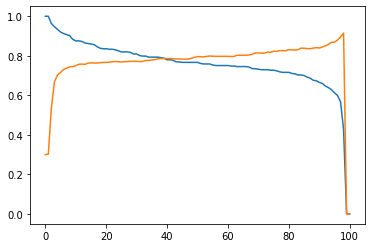

In [ ]:
plt.plot(recall)
plt.plot(precision)

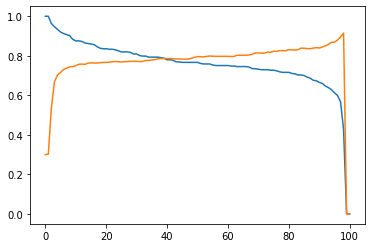

In [ ]:
plt.plot(recall)
plt.plot(precision)

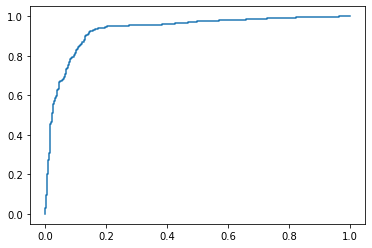

In [218]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='roc')